# 1. Load packages

In [116]:
import scipy.sparse as sp
import pandas as pd
import scanpy as sc
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
from mygene import MyGeneInfo

In [117]:
import numpy as np
np.NAN = np.nan

In [118]:
import omnipath as op

In [119]:
from markov_clustering import run_mcl, get_clusters

In [120]:
from matplotlib.colors import rgb2hex

In [121]:
import leidenalg

# 2. load node data

In [122]:
from pathlib import Path
import pandas as pd

# 1️⃣ Load prepared data
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

prot_expr_mean = pd.read_csv(in_dir / "proteome_expr_mean.csv", index_col=0)
phospho_expr_mean = pd.read_csv(in_dir / "phosphoproteome_expr_mean.csv", index_col=0)
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

prot_fc = pd.read_csv(in_dir / "proteome_fc.csv", index_col=0)
phospho_fc = pd.read_csv(in_dir / "phosphoproteome_fc.csv", index_col=0)

detected_uniprots = pd.read_csv(in_dir / "detected_uniprots.txt", header=None)[0].tolist()

print(f"Loaded {len(detected_uniprots)} detected UniProt IDs.")
print(f"Combined table: {combined_expr_mean.shape}")


Loaded 2916 detected UniProt IDs.
Combined table: (2915, 28)


In [123]:
phospho_fc

,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800,psite_id,gene_symbol
UniProt,,,,,,,,,,,
A0A1B0GUW6,-0.487630,0.237964,0.609327,-0.121132,0.768297,0.940300,-1.182801,0.005222,0.070003,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,A0A1B0GUW6
A0FGR8,0.112968,0.561838,0.836479,-0.631699,0.001758,0.061496,0.024567,0.899486,0.951119,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,ESYT2
A0FGR8,-0.336258,0.216695,0.585516,0.364801,0.180614,0.546526,0.488185,0.074705,0.302857,A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581,ESYT2
A0FGR8,0.214166,0.098726,0.419050,0.162217,0.209094,0.569764,0.333042,0.011357,0.106868,A0FGR8;ESYT2;S739;SSSSLLASPGHISVK;2582,ESYT2
A0FGR8,0.177454,0.753409,0.918455,0.484828,0.391870,0.741377,0.658353,0.246055,0.541253,A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736,ESYT2
...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6M1,0.196720,0.080672,0.393156,-0.028385,0.798778,0.952402,0.354017,0.002158,0.046987,Q9Y6M1;IGF2BP2;S162;ISYIPDEEVSSPSPPQR;698,IGF2BP2
Q9Y6M7,-0.544588,0.125577,0.455553,0.391082,0.269275,0.642588,1.009433,0.005417,0.071691,Q9Y6M7;SLC4A7;S242;KHSDPHLLER;4036,SLC4A7
Q9Y6N5,-0.429944,0.052719,0.322845,0.284007,0.197085,0.554106,-0.303134,0.168953,0.448447,Q9Y6N5;SQOR;S343;YPNVFGIGDCTNLPTSK;1825,SQOR


# 3. Get edges

## 3.1.  Download OmniPath interactions

In [124]:
from omnipath.interactions import OmniPath

# 1. See what parameters and resources are available
print("Query params:", OmniPath.params())        # dict of valid query-args :contentReference[oaicite:0]{index=0}
print("All resources:", OmniPath.resources())    # tuple of resource names :contentReference[oaicite:1]{index=1}

# 2. Download the full curated OmniPath network
inter = OmniPath.get()                          
print(f"Raw OmniPath: {inter.shape[0]:,} interactions")   # DataFrame



Query params: {'header': None, 'format': frozenset({'tab', 'tsv', 'table', 'json', 'text'}), 'license': frozenset({'for_profit', 'commercial', 'ignore', 'nonprofit', 'non_profit', 'academic', 'forprofit'}), 'password': None, 'limit': None, 'types': frozenset({'small_molecule_protein', 'post_translational', 'mirna_transcriptional', 'transcriptional', 'post_transcriptional', 'lncrna_post_transcriptional'}), 'sources': None, 'resources': None, 'databases': frozenset({'DoRothEA-reviews_DoRothEA', 'Wojtowicz2020', 'SIGNOR', 'UniProt_LRdb', 'STRING_talklr', 'ENCODE-distal', 'SignaLink3', 'ENCODE_tf-mirna', 'CollecTRI', 'talklr', 'ncRDeathDB', 'Reactome_SignaLink3', 'Cellinker', 'SPIKE_LC', 'RLIMS-P_ProtMapper', 'ARN', 'EMBRACE', 'GOA_CollecTRI', 'HPMR_talklr', 'KEGG-MEDICUS', 'NFIRegulomeDB_DoRothEA', 'KEGG', 'HPRD', 'PDZBase', 'IntAct', 'HTRI_CollecTRI', 'PhosphoSite_noref', 'HPRD_KEA', 'CancerDrugsDB', 'SPIKE', 'MIMP', 'BEL-Large-Corpus_ProtMapper', 'TRRUST_DoRothEA', 'PhosphoNetworks', 'G

In [125]:
# --- Define which resources to focus on (if desired) ---
focus_resources = [
    # Core signaling
    "KEGG", "Reactome", "SIGNOR",
    # Gene regulons
    "DoRothEA", "TRRUST",
    # PPI scaffold
    "BioGRID", "IntAct",
    # PTM detail (optional)
    "PhosphoSite", "iPTMnet",
    # Cell–cell communication
    "CellPhoneDB",
    # Legacy / additional
    "UniProt_LRdb", "HPRD", "Adhesome"
]

# --- Toggle filtering ---
use_mask = False  # Set to False to skip filtering by source

# --- Apply mask if requested ---
if use_mask:
    mask = inter["sources"].str.split(";").apply(
        lambda srcs: any(r in srcs for r in focus_resources)
    )
    inter = inter.loc[mask].copy()
    print(f"After resource filter: {inter.shape[0]:,} interactions")
else:
    print(f"Skipping resource filter: using all {inter.shape[0]:,} interactions")


Skipping resource filter: using all 81,529 interactions


In [126]:
inter

,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0DP23,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
1,P0DP25,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
2,P0DP24,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
3,Q03135,P48995,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,P14416,P48995,True,True,False,True,True,False,1,TRIP:18261457,TRIP,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81524,P12931,Q9UJM3,True,False,False,False,False,False,2,ProtMapper:26280531;iPTMnet:26280531,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,26280531
81525,P43405,Q9ULZ3,True,False,False,False,False,False,2,ProtMapper:25605870;iPTMnet:25605870,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,25605870
81526,Q14289,Q9ULZ3,True,False,False,False,False,False,2,ProtMapper:27796369;iPTMnet:27796369,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,27796369
81527,P54646,Q9Y2I7,True,False,False,False,False,False,1,iPTMnet:24070423,iPTMnet,1,1,1,24070423


## 3.2.  Quality filters  (mirror your R code)

In [127]:
import numpy as np

# 1. Copy from the correct DataFrame (not the built-in iter)
df = inter.copy()

# 2. Base QC: curation effort & consensus direction
df = df[df["curation_effort"] >= 2]
#df = df[df["consensus_direction"] == 2]

# 3. Assign signed “type” and drop ambiguous edges
df["type"] = np.nan
df.loc[
    df["is_stimulation"].astype(bool) | df["consensus_stimulation"].astype(bool),
    "type"
] = "activation"
df.loc[
    df["is_inhibition"].astype(bool)  | df["consensus_inhibition"].astype(bool),
    "type"
] = "inhibition"
df = df.dropna(subset=["type"])

# 4. Publication support: ≥2 distinct papers
df = df[df["n_references"] >= 2]

# 5. Cross-resource consensus: seen in ≥2 resources
df = df[df["n_sources"] >= 1]

print(f"Rows after HQ filtering: {df.shape[0]:,}")
df.head()


Rows after HQ filtering: 10,135


/tmp/ipykernel_485052/1354645508.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'activation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[


,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped,type
0,P0DP23,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176,inhibition
1,P0DP25,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176,inhibition
2,P0DP24,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176,inhibition
3,Q03135,P48995,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...,activation
5,Q99750,P48995,True,False,True,True,False,True,3,HPRD:14530267;TRIP:14530267;TRIP:23770672,HPRD;TRIP,2,2,2,14530267;23770672,inhibition


## 3.3.  Quick glance at interaction types

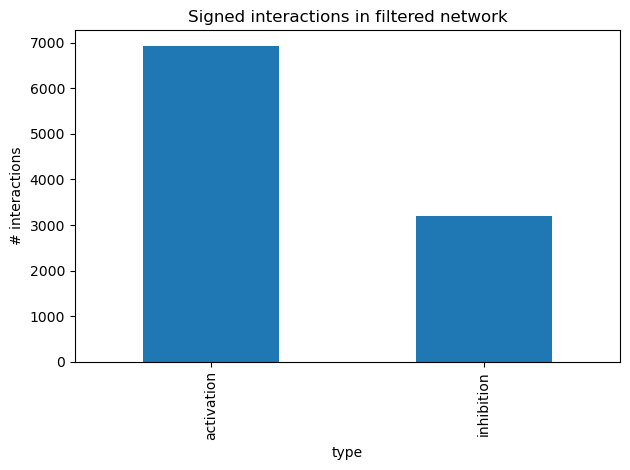

In [128]:
type_counts = df["type"].value_counts()
ax = type_counts.plot(kind="bar")
ax.set_ylabel("# interactions")
ax.set_title("Signed interactions in filtered network")
plt.tight_layout()
plt.show()

# 4. Build networks

## 4.0 inspect combined intensity table

In [129]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load combined table
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

print(f"Combined expression table shape: {combined_expr_mean.shape}")
display(combined_expr_mean.head(20))

# Optionally inspect numeric vs annotation columns
print("Numeric columns:", [c for c in combined_expr_mean.columns if combined_expr_mean[c].dtype != "object"][:10])
print("Non-numeric columns:", [c for c in combined_expr_mean.columns if combined_expr_mean[c].dtype == "object"])


Combined expression table shape: (2915, 28)


,10_CXCR7_prot,600_CXCR7_prot,1800_CXCR7_prot,0_Ctrl_prot,10_DMSO_prot,600_DMSO_prot,1800_DMSO_prot,source_prot,10_CXCR7_phos,600_CXCR7_phos,...,has_phospho,10_CXCR7_combined,600_CXCR7_combined,1800_CXCR7_combined,0_Ctrl_combined,10_DMSO_combined,600_DMSO_combined,1800_DMSO_combined,source_combined,haspho_combined
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,proteome,NaN,NaN,...,False,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,proteome,False
A0A0A0MS15,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,proteome,NaN,NaN,...,False,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,proteome,False
A0A0B4J1U7,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,proteome,NaN,NaN,...,False,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,proteome,False
A0A0B4J1X5,29.572116,29.697423,29.649465,29.559103,29.488391,29.691739,29.613414,proteome,NaN,NaN,...,False,29.572116,29.697423,29.649465,29.559103,29.488391,29.691739,29.613414,proteome,False
A0A0B4J1Y9,24.277022,24.283101,24.288321,24.264258,24.315194,24.220384,24.255841,proteome,NaN,NaN,...,False,24.277022,24.283101,24.288321,24.264258,24.315194,24.220384,24.255841,proteome,False
A0A0C4DH43,20.924079,20.710393,20.581266,20.630867,20.622972,20.419420,20.562545,proteome,NaN,NaN,...,False,20.924079,20.710393,20.581266,20.630867,20.622972,20.419420,20.562545,proteome,False
A0A1B0GUW6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.967803,19.470706,...,True,18.967803,19.470706,18.427843,19.243985,19.455433,19.591838,19.610643,phosphoproteome,True
A0AVT1,11.487514,11.534193,11.517483,11.584648,11.445340,11.451980,11.441634,proteome,NaN,NaN,...,False,11.487514,11.534193,11.517483,11.584648,11.445340,11.451980,11.441634,proteome,False
A0FGR8,20.622261,20.631675,20.665422,20.621037,20.614230,20.658704,20.621974,proteome,23.589772,22.860872,...,True,23.589772,22.860872,23.348017,23.535857,23.476804,23.492571,23.323450,phosphoproteome,True


Numeric columns: ['10_CXCR7_prot', '600_CXCR7_prot', '1800_CXCR7_prot', '0_Ctrl_prot', '10_DMSO_prot', '600_DMSO_prot', '1800_DMSO_prot', '10_CXCR7_phos', '600_CXCR7_phos', '1800_CXCR7_phos']
Non-numeric columns: ['source_prot', 'source_phos', 'gene_symbol', 'source_combined']


In [130]:
print( combined_expr_mean.columns)

Index(['10_CXCR7_prot', '600_CXCR7_prot', '1800_CXCR7_prot', '0_Ctrl_prot',
       '10_DMSO_prot', '600_DMSO_prot', '1800_DMSO_prot', 'source_prot',
       '10_CXCR7_phos', '600_CXCR7_phos', '1800_CXCR7_phos', '0_Ctrl_phos',
       '10_DMSO_phos', '600_DMSO_phos', '1800_DMSO_phos', 'source_phos',
       'gene_symbol', 'has_proteome', 'has_phospho', '10_CXCR7_combined',
       '600_CXCR7_combined', '1800_CXCR7_combined', '0_Ctrl_combined',
       '10_DMSO_combined', '600_DMSO_combined', '1800_DMSO_combined',
       'source_combined', 'haspho_combined'],
      dtype='object')


## 4.1 big network 

In [131]:
import igraph as ig
import pandas as pd

# ======================================================
# ⚙️ 1. Load prepared data (if not already in memory)
# ======================================================
from pathlib import Path
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)
detected_uniprots = combined_expr_mean.index.tolist()

print(f"Detected UniProt IDs: {len(detected_uniprots)}")


# ======================================================
# 🧠 2. Filter OmniPath edges to measured nodes
# ======================================================
df_expr = df[
    df["source"].isin(detected_uniprots) &
    df["target"].isin(detected_uniprots)
].copy()

print(f"Edges after expression filter: {df_expr.shape[0]:,} of {df.shape[0]:,}")


# ======================================================
# 🧬 3. Build mapping UniProt → gene symbol
# ======================================================
symbol_map = combined_expr_mean["gene_symbol"].to_dict()


# ======================================================
# 🧩 4. Annotate edges with source/target symbols
# ======================================================
df_expr["source_symbol"] = df_expr["source"].map(symbol_map)
df_expr["target_symbol"] = df_expr["target"].map(symbol_map)


# ======================================================
# 🔗 5. Build igraph network
# ======================================================
edge_tuples = df_expr[["source", "target", "type"]].itertuples(index=False, name=None)

g_full = ig.Graph.TupleList(
    edge_tuples,
    directed=True,
    edge_attrs=["type"]
)

print(f"🌐 Global network constructed:")
print(f"   Nodes: {g_full.vcount():,}")
print(f"   Edges: {g_full.ecount():,}")


# ======================================================
# 🧩 6. Annotate vertices with symbols and metadata
# ======================================================
g_full.vs["gene_symbol"] = [symbol_map.get(v["name"], v["name"]) for v in g_full.vs]

# Optional: Mark which nodes have proteome/phosphoproteome data
has_prot = combined_expr_mean.loc[:, "has_proteome"].to_dict() if "has_proteome" in combined_expr_mean.columns else {}
has_phos = combined_expr_mean.loc[:, "has_phospho"].to_dict() if "has_phospho" in combined_expr_mean.columns else {}

g_full.vs["has_proteome"] = [has_prot.get(v["name"], False) for v in g_full.vs]
g_full.vs["has_phospho"] = [has_phos.get(v["name"], False) for v in g_full.vs]


# ======================================================
# 🔍 7. Preview and sanity check
# ======================================================
print("Example vertices:")
for v in g_full.vs[:10]:
    print(f"{v['name']:<12} → {v['gene_symbol']:<10} | prot:{v['has_proteome']} | phos:{v['has_phospho']}")

print("\nExample edges:")
print(df_expr.sample(5))


Detected UniProt IDs: 2915
Edges after expression filter: 1,585 of 10,135
🌐 Global network constructed:
   Nodes: 647
   Edges: 1,585
Example vertices:
P0DP24       → CALM2      | prot:True | phos:False
Q9Y210       → TRPC6      | prot:True | phos:True
P06241       → FYN        | prot:True | phos:True
P49137       → MAPKAPK2   | prot:True | phos:True
Q16539       → MAPK14     | prot:True | phos:True
P31749       → AKT1       | prot:True | phos:True
O15111       → CHUK       | prot:True | phos:False
P19838       → NFKB1      | prot:True | phos:False
P27986       → PIK3R1     | prot:True | phos:False
P78536       → ADAM17     | prot:False | phos:True

Example edges:
      source  target  is_directed  is_stimulation  is_inhibition  \
9295  P28482  Q96SB3         True            True          False   
2925  P27361  P40763         True            True           True   
6214  P08575  P23458         True            True           True   
2325  P22681  P07948         True            True      

## 4.2. Extract Giant Connected Component (GCC)

In [143]:
import igraph as ig

print("Vertex attributes:", g_full.vs.attributes())
print("Edge attributes:", g_full.es.attributes())

# Build GCC (weakly connected)
components = g_full.components(mode="weak")
g_gcc = components.giant()

print(f"🌐 Global network: {g_full.vcount()} nodes, {g_full.ecount()} edges")
print(f"🧩 Largest component (GCC): {g_gcc.vcount()} nodes, {g_gcc.ecount()} edges")


Vertex attributes: ['name', 'gene_symbol', 'has_proteome', 'has_phospho']
Edge attributes: ['type']
🌐 Global network: 647 nodes, 1585 edges
🧩 Largest component (GCC): 581 nodes, 1547 edges


## 4.3 Build GCC & Subnetworks with Source-Specific Thresholds

In [135]:
import igraph as ig
import pandas as pd
import numpy as np
from pathlib import Path

# ======================================================
# ⚙️ 1. Parameters
# ======================================================
# You can change these freely before running
PROTEOME_THRESHOLD = 5
PHOSPHO_THRESHOLD = 2.5
THRESHOLD_MODE = "fixed"  # "fixed" or "quantile"
QUANTILE = 0.05           # if using quantile mode

print(f"🧩 Using thresholds — Proteome: {PROTEOME_THRESHOLD}, Phospho: {PHOSPHO_THRESHOLD}")

# ======================================================
# 📂 2. Load and inspect combined expression data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"
merged = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

print(f"Loaded merged table: {merged.shape}")
display(merged.head(5))

# Identify combined expression columns
combined_cols = [c for c in merged.columns if "_combined" in c]
print(f"Detected {len(combined_cols)} combined columns")

# --- Force numeric ---
merged[combined_cols] = merged[combined_cols].apply(pd.to_numeric, errors="coerce")

# Verify datatypes
print("Numeric dtype columns confirmed:", merged[combined_cols].dtypes.unique())

# ======================================================
# ⚖️ 3. Optional: data-driven threshold mode
# ======================================================
if THRESHOLD_MODE == "quantile":
    PROTEOME_THRESHOLD = merged.loc[
        merged["source_combined"] == "proteome", combined_cols
    ].stack().quantile(QUANTILE)
    PHOSPHO_THRESHOLD = merged.loc[
        merged["source_combined"] == "phosphoproteome", combined_cols
    ].stack().quantile(QUANTILE)
    print(f"📊 Data-driven thresholds (q={QUANTILE*100:.0f}%):")
    print(f" - Proteome: {PROTEOME_THRESHOLD:.2f}")
    print(f" - Phosphoproteome: {PHOSPHO_THRESHOLD:.2f}")

# ======================================================
# 🌐 4. Extract Giant Connected Component (GCC)
# ======================================================
components = g_full.components(mode="weak")
g_gcc = components.giant()

print(f"🌍 Full network: {g_full.vcount()} nodes, {g_full.ecount()} edges")
print(f"🧩 GCC: {g_gcc.vcount()} nodes, {g_gcc.ecount()} edges")

# ======================================================
# 🧮 4b. Betweenness Centrality for GCC
# ======================================================
print("\n=== 🔍 Computing global GCC betweenness centrality ===")

# Compute betweenness, in/out degree
btwn_gcc = g_gcc.betweenness(directed=True)
in_deg = g_gcc.degree(mode="in")
out_deg = g_gcc.degree(mode="out")

# Collect stats
gcc_stats = pd.DataFrame({
    "uniprot_id": g_gcc.vs["name"],
    "gene_symbol": g_gcc.vs["gene_symbol"],
    "betweenness": btwn_gcc,
    "in_degree": in_deg,
    "out_degree": out_deg,
    "total_degree": g_gcc.degree(),
})

# Sort by betweenness
gcc_stats = gcc_stats.sort_values("betweenness", ascending=False)
print(f"GCC contains {len(gcc_stats)} nodes.")
print("Top 40 nodes by betweenness:")

display(gcc_stats.head(40))

# Save results
gcc_stats.to_csv(in_dir.parent / "gcc_centrality.csv", index=False)
print(f"✅ Saved GCC betweenness table to: {in_dir.parent / 'gcc_centrality.csv'}")


# ======================================================
# 🧮 5. Active node selection function
# ======================================================
def get_active_nodes(df, condition, prot_thr, phos_thr):
    """
    Return active UniProt IDs for given condition/timepoint.
    Uses source-specific threshold:
      - phosphoproteome → phospho_threshold
      - proteome → prot_threshold
    """
    expr_col = f"{condition}_combined"
    src_col = "source_combined"

    # Skip if column missing
    if expr_col not in df.columns:
        print(f"⚠️ Missing column: {expr_col}")
        return []

    # Ensure numeric
    expr_vals = pd.to_numeric(df[expr_col], errors="coerce")

    active = df.index[
        ((df[src_col] == "phosphoproteome") & (expr_vals > phos_thr)) |
        ((df[src_col] != "phosphoproteome") & (expr_vals > prot_thr))
    ].tolist()
    return active


# ======================================================
# 🧩 6. Build subnetworks per condition × timepoint
# ======================================================
conditions = [c.replace("_combined", "") for c in combined_cols]
subnetworks = {}

for cond in conditions:
    active_nodes = get_active_nodes(merged, cond, PROTEOME_THRESHOLD, PHOSPHO_THRESHOLD)
    active_nodes = [n for n in active_nodes if n in g_gcc.vs["name"]]  # ensure in GCC

    sub_g = g_gcc.subgraph(g_gcc.vs.select(name_in=active_nodes))
    subnetworks[cond] = sub_g

    print(f"{cond:<12}: {sub_g.vcount():>4} nodes, {sub_g.ecount():>5} edges")


# ======================================================
# 📊 7. Compute centrality metrics
# ======================================================
def summarize_network(g, label):
    btwn = g.betweenness(directed=True)
    return pd.DataFrame({
        "uniprot_id": g.vs["name"],
        "gene_symbol": g.vs["gene_symbol"],
        "betweenness": btwn,
        "degree": g.degree(),
        "in_degree": g.degree(mode="in"),
        "out_degree": g.degree(mode="out"),
        "density": g.density(),
        "network": label
    })

subnet_metrics = pd.concat(
    [summarize_network(g, cond) for cond, g in subnetworks.items()],
    ignore_index=True
)

print(f"\n✅ Computed metrics for {len(subnetworks)} subnetworks ({subnet_metrics.shape[0]} total entries)")
display(subnet_metrics.head(10))

# ======================================================
# 💾 8. Save subnetworks + metrics
# ======================================================

out_dir = in_dir.parent / "subnetworks"
out_dir.mkdir(exist_ok=True)

subnet_metrics.to_csv(out_dir / "subnetwork_metrics.csv", index=False)

# Export each subnetwork to GraphML for Cytoscape / PANCy
for cond, g_sub in subnetworks.items():
    out_path = str(out_dir / f"{cond}_subnetwork.graphml")  # convert Path → str
    g_sub.write_graphml(out_path)

print(f"✅ Exported subnetworks and metrics to: {out_dir}")



🧩 Using thresholds — Proteome: 5, Phospho: 2.5
Loaded merged table: (2915, 28)


,10_CXCR7_prot,600_CXCR7_prot,1800_CXCR7_prot,0_Ctrl_prot,10_DMSO_prot,600_DMSO_prot,1800_DMSO_prot,source_prot,10_CXCR7_phos,600_CXCR7_phos,...,has_phospho,10_CXCR7_combined,600_CXCR7_combined,1800_CXCR7_combined,0_Ctrl_combined,10_DMSO_combined,600_DMSO_combined,1800_DMSO_combined,source_combined,haspho_combined
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,proteome,NaN,NaN,...,False,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,proteome,False
A0A0A0MS15,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,proteome,NaN,NaN,...,False,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,proteome,False
A0A0B4J1U7,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,proteome,NaN,NaN,...,False,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,proteome,False
A0A0B4J1X5,29.572116,29.697423,29.649465,29.559103,29.488391,29.691739,29.613414,proteome,NaN,NaN,...,False,29.572116,29.697423,29.649465,29.559103,29.488391,29.691739,29.613414,proteome,False
A0A0B4J1Y9,24.277022,24.283101,24.288321,24.264258,24.315194,24.220384,24.255841,proteome,NaN,NaN,...,False,24.277022,24.283101,24.288321,24.264258,24.315194,24.220384,24.255841,proteome,False


Detected 9 combined columns
Numeric dtype columns confirmed: [dtype('float64') dtype('bool')]
🌍 Full network: 647 nodes, 1585 edges
🧩 GCC: 581 nodes, 1547 edges

=== 🔍 Computing global GCC betweenness centrality ===
GCC contains 581 nodes.
Top 40 nodes by betweenness:


,uniprot_id,gene_symbol,betweenness,in_degree,out_degree,total_degree
129,P12931,SRC,30798.463860,33,77,110
5,P31749,AKT1,26749.364661,21,49,70
12,P17252,PRKCA,19551.671854,15,65,80
60,P28482,MAPK1,16230.523031,18,53,71
4,Q16539,MAPK14,12885.704631,16,19,35
136,P17612,PRKACA,11151.562233,10,54,64
23,P63000,RAC1,10651.000049,24,16,40
16,P42574,CASP3,9960.129944,2,18,20
84,P35568,IRS1,8804.192305,16,11,27
43,P55211,CASP9,8241.389418,12,4,16


✅ Saved GCC betweenness table to: analysis/networks/gcc_centrality.csv
10_CXCR7    :  547 nodes,  1433 edges
600_CXCR7   :  547 nodes,  1436 edges
1800_CXCR7  :  547 nodes,  1433 edges
0_Ctrl      :  549 nodes,  1439 edges
10_DMSO     :  549 nodes,  1439 edges
600_DMSO    :  548 nodes,  1438 edges
1800_DMSO   :  548 nodes,  1438 edges
source      :    0 nodes,     0 edges
haspho      :    0 nodes,     0 edges

✅ Computed metrics for 9 subnetworks (3835 total entries)


,uniprot_id,gene_symbol,betweenness,degree,in_degree,out_degree,density,network
0,P0DP24,CALM2,0.000000,4.0,0.0,4.0,0.004798,10_CXCR7
1,Q9Y210,TRPC6,0.000000,2.0,2.0,0.0,0.004798,10_CXCR7
2,P06241,FYN,2744.483897,41.0,9.0,32.0,0.004798,10_CXCR7
3,P49137,MAPKAPK2,1181.999713,12.0,3.0,9.0,0.004798,10_CXCR7
4,Q16539,MAPK14,12726.099920,35.0,16.0,19.0,0.004798,10_CXCR7
5,P31749,AKT1,24652.106107,69.0,21.0,48.0,0.004798,10_CXCR7
6,O15111,CHUK,845.535108,12.0,9.0,3.0,0.004798,10_CXCR7
7,P19838,NFKB1,1454.607599,7.0,5.0,2.0,0.004798,10_CXCR7
8,P27986,PIK3R1,1194.959605,14.0,10.0,4.0,0.004798,10_CXCR7
9,P78536,ADAM17,639.552684,5.0,3.0,2.0,0.004798,10_CXCR7


✅ Exported subnetworks and metrics to: analysis/networks/subnetworks


## 4.4 Check for proteins of interest

In [155]:
import pandas as pd
import igraph as ig

def inspect_protein_across_layers(
    gene_symbol,
    uniprot_id,
    inter,         # raw OmniPath
    df,            # HQ filtered OmniPath
    combined_expr_mean,
    df_expr,       # expression-filtered OmniPath
    g_gcc          # network (giant component)
):
    """Inspect a protein across multiple dataset layers."""

    def _section(title):
        print("=" * 70)
        print(f"🔎 Inspecting: {title}")
        print("=" * 70)

    print(f"\n🔬 Checking presence of {gene_symbol} ({uniprot_id}) across datasets...\n")

    # ======================================================
    # 1️⃣ Raw OmniPath
    # ======================================================
    _section("1️⃣ Raw OmniPath (unfiltered)")
    raw_hits = inter[(inter["source"] == uniprot_id) | (inter["target"] == uniprot_id)]
    print(f"📦 Raw OmniPath total: {len(inter):,} edges")
    print(f" → {len(raw_hits):,} edges involve {gene_symbol}")
    display(raw_hits.head(10)) if not raw_hits.empty else print(f"⚠️ {gene_symbol} not found in raw OmniPath.")

    # ======================================================
    # 2️⃣ HQ Filtered OmniPath
    # ======================================================
    _section("2️⃣ HQ Filtered OmniPath (after curation filter)")
    filt_hits = df[(df["source"] == uniprot_id) | (df["target"] == uniprot_id)]
    print(f"📊 Filtered OmniPath total: {len(df):,} edges")
    print(f" → {len(filt_hits):,} edges involve {gene_symbol}")
    display(filt_hits.head(10)) if not filt_hits.empty else print(f"⚠️ {gene_symbol} not found in HQ-filtered OmniPath.")

    # ======================================================
    # 3️⃣ Expression Table
    # ======================================================
    _section("3️⃣ Expression Table (combined_expr_mean.csv)")
    if uniprot_id in combined_expr_mean.index:
        expr_hit = combined_expr_mean.loc[[uniprot_id]]
        print(f"✅ {gene_symbol} ({uniprot_id}) present in expression data.")
        display(expr_hit.filter(regex='_combined|gene_symbol'))
    else:
        print(f"⚠️ {gene_symbol} not present in expression table.")

    # ======================================================
    # 4️⃣ Expression-Filtered OmniPath
    # ======================================================
    _section("4️⃣ Expression-Filtered OmniPath (edges between expressed nodes)")
    expr_filt_hits = df_expr[(df_expr["source"] == uniprot_id) | (df_expr["target"] == uniprot_id)]
    print(f"🧬 Expression-filtered OmniPath total: {len(df_expr):,} edges")
    print(f" → {len(expr_filt_hits):,} edges involve {gene_symbol}")
    display(expr_filt_hits.head(10)) if not expr_filt_hits.empty else print(f"⚠️ {gene_symbol} not found among expressed-node edges.")

    # ======================================================
    # 5️⃣ GCC (network-level representation)
    # ======================================================
    _section("5️⃣ Network representation (GCC)")
    if g_gcc is None or g_gcc.vcount() == 0:
        print("⚠️ GCC network not available or empty.")
        return

    matches = [v for v in g_gcc.vs if v["name"] == uniprot_id or v["gene_symbol"] == gene_symbol]
    if not matches:
        print(f"⚠️ {gene_symbol} ({uniprot_id}) not found in GCC network.")
    else:
        v = matches[0]
        indeg = g_gcc.degree(v, mode="in")
        outdeg = g_gcc.degree(v, mode="out")
        totaldeg = indeg + outdeg
        btw = g_gcc.betweenness(v)
        if isinstance(btw, list):
            btw = btw[0]
        print(f"✅ {gene_symbol} ({uniprot_id}) is represented in GCC.")
        print(f"  In-degree:  {indeg}")
        print(f"  Out-degree: {outdeg}")
        print(f"  Total degree: {totaldeg}")
        print(f"  Betweenness: {btw:.4f}")

        # --- Extract top interacting nodes ---
        # Incoming partners
        in_edges = g_gcc.incident(v, mode="in")
        out_edges = g_gcc.incident(v, mode="out")

        def get_partner_names(edge_list, direction):
            partners = []
            for e in edge_list:
                eid = g_gcc.es[e]
                src, tgt = eid.source, eid.target
                partner = src if direction == "in" else tgt
                partner_gene = g_gcc.vs[partner]["gene_symbol"]
                partner_uid = g_gcc.vs[partner]["name"]
                partners.append((partner_gene, partner_uid))
            return partners

        in_partners = get_partner_names(in_edges, "in")
        out_partners = get_partner_names(out_edges, "out")

        print(f"\n  🔼 Top incoming nodes ({len(in_partners)} total):")
        if in_partners:
            for gsym, uid in in_partners[:10]:
                print(f"   - {gsym} ({uid})")
        else:
            print("   None")

        print(f"\n  🔽 Top outgoing nodes ({len(out_partners)} total):")
        if out_partners:
            for gsym, uid in out_partners[:10]:
                print(f"   - {gsym} ({uid})")
        else:
            print("   None")

    # ======================================================
    # ✅ Summary
    # ======================================================
    print("\n✅ Summary:")
    print(f"  Raw OmniPath edges:        {len(raw_hits):>5}")
    print(f"  HQ Filtered OmniPath:      {len(filt_hits):>5}")
    print(f"  Expression Table present:  {uniprot_id in combined_expr_mean.index}")
    print(f"  Expressed-node edges:      {len(expr_filt_hits):>5}")
    print(f"  In GCC network:            {len(matches) > 0}")
    print("=" * 70)



# ======================================================
# 🧠 Example usage
# ======================================================
inspect_protein_across_layers(
    gene_symbol="PRKG1",
    uniprot_id="Q13976",
    inter=inter,               # raw OmniPath
    df=df,                     # HQ filtered OmniPath
    combined_expr_mean=combined_expr_mean,
    df_expr=df_expr,           # expressed-node filtered edges
    g_gcc=g_gcc                # GCC network
)



🔬 Checking presence of PRKG1 (Q13976) across datasets...

🔎 Inspecting: 1️⃣ Raw OmniPath (unfiltered)
📦 Raw OmniPath total: 81,529 edges
 → 108 edges involve PRKG1


,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
32,Q13976,Q13507,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
53,Q13976,Q9HCX4,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2146,Q13976,O14974,True,True,True,True,False,True,8,HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...,HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...,10,7,4,10567269;10579722;15194681;19120700
8932,Q13976,Q9Y613,True,True,False,True,True,False,10,HPRD:15051728;KEA:15051728;PhosphoSite:1505172...,HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...,15,9,2,15051728;21106951
9838,Q13976,P11831,True,True,False,True,True,False,2,ProtMapper:19778940;SIGNOR:12809504,MIMP;PhosphoSite_MIMP;PhosphoSite_ProtMapper;P...,7,3,2,12809504;19778940
10125,Q13976,P41220,True,True,False,True,True,False,10,HPRD-phos:14608379;HPRD:14608379;KEA:14608379;...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Net...,19,10,3,14608379;17570479;24777815
10968,P17252,Q13976,True,True,False,True,True,False,9,HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...,18,10,2,12609995;17570479
12129,Q13976,Q9UH03,True,True,False,True,True,False,5,HPRD-phos:15107017;HPRD:15107017;KEA:15107017;...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...,10,6,1,15107017
12590,Q13976,Q14847,True,False,True,True,False,True,7,HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...,BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...,15,8,2,12432067;12571245
13896,Q13976,Q15637,True,False,True,True,False,True,9,HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...,15,9,2,10449420;17287340


🔎 Inspecting: 2️⃣ HQ Filtered OmniPath (after curation filter)
📊 Filtered OmniPath total: 10,135 edges
 → 18 edges involve PRKG1


,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped,type
32,Q13976,Q13507,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690,inhibition
2146,Q13976,O14974,True,True,True,True,False,True,8,HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...,HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...,10,7,4,10567269;10579722;15194681;19120700,inhibition
8932,Q13976,Q9Y613,True,True,False,True,True,False,10,HPRD:15051728;KEA:15051728;PhosphoSite:1505172...,HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...,15,9,2,15051728;21106951,activation
9838,Q13976,P11831,True,True,False,True,True,False,2,ProtMapper:19778940;SIGNOR:12809504,MIMP;PhosphoSite_MIMP;PhosphoSite_ProtMapper;P...,7,3,2,12809504;19778940,activation
10125,Q13976,P41220,True,True,False,True,True,False,10,HPRD-phos:14608379;HPRD:14608379;KEA:14608379;...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Net...,19,10,3,14608379;17570479;24777815,activation
10968,P17252,Q13976,True,True,False,True,True,False,9,HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...,18,10,2,12609995;17570479,activation
12590,Q13976,Q14847,True,False,True,True,False,True,7,HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...,BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...,15,8,2,12432067;12571245,inhibition
13896,Q13976,Q15637,True,False,True,True,False,True,9,HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...,15,9,2,10449420;17287340,inhibition
14441,Q13976,P04792,True,False,True,True,False,True,9,KEA:17570479;PhosphoSite:17351657;PhosphoSite:...,HPRD_MIMP;KEA;MIMP;NetworKIN_KEA;PhosphoSite;P...,15,6,7,11383510;17351657;17570479;18720982;19593530;2...,inhibition
14625,Q13976,P35367,True,False,True,True,False,True,9,KEA:10101032;KEA:15107581;ProtMapper:10101032;...,KEA;MIMP;PhosphoPoint;PhosphoSite_KEA;PhosphoS...,12,7,2,10101032;15107581,inhibition


🔎 Inspecting: 3️⃣ Expression Table (combined_expr_mean.csv)
✅ PRKG1 (Q13976) present in expression data.


,gene_symbol,10_CXCR7_combined,600_CXCR7_combined,1800_CXCR7_combined,0_Ctrl_combined,10_DMSO_combined,600_DMSO_combined,1800_DMSO_combined,source_combined,haspho_combined
UniProt,,,,,,,,,,
Q13976,PRKG1,11.572649,11.762265,11.785922,11.818758,11.956233,11.565544,11.556775,phosphoproteome,True


🔎 Inspecting: 4️⃣ Expression-Filtered OmniPath (edges between expressed nodes)
🧬 Expression-filtered OmniPath total: 1,585 edges
 → 11 edges involve PRKG1


,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped,type,source_symbol,target_symbol
2146,Q13976,O14974,True,True,True,True,False,True,8,HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...,HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...,10,7,4,10567269;10579722;15194681;19120700,inhibition,PRKG1,PPP1R12A
8932,Q13976,Q9Y613,True,True,False,True,True,False,10,HPRD:15051728;KEA:15051728;PhosphoSite:1505172...,HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...,15,9,2,15051728;21106951,activation,PRKG1,FHOD1
10968,P17252,Q13976,True,True,False,True,True,False,9,HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...,18,10,2,12609995;17570479,activation,PRKCA,PRKG1
12590,Q13976,Q14847,True,False,True,True,False,True,7,HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...,BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...,15,8,2,12432067;12571245,inhibition,PRKG1,LASP1
13896,Q13976,Q15637,True,False,True,True,False,True,9,HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...,15,9,2,10449420;17287340,inhibition,PRKG1,SF1
14441,Q13976,P04792,True,False,True,True,False,True,9,KEA:17570479;PhosphoSite:17351657;PhosphoSite:...,HPRD_MIMP;KEA;MIMP;NetworKIN_KEA;PhosphoSite;P...,15,6,7,11383510;17351657;17570479;18720982;19593530;2...,inhibition,PRKG1,HSPB1
32976,Q13976,P50552,True,True,True,True,False,True,32,HPRD-phos:12576312;HPRD-phos:17287340;HPRD-pho...,BEL-Large-Corpus_ProtMapper;HPRD;HPRD-phos;HPR...,21,8,18,10851246;10922374;12576312;14679200;15066263;1...,inhibition,PRKG1,VASP
44739,Q13976,Q01970,True,False,True,True,False,True,11,HPRD-phos:11278298;HPRD-phos:19651622;HPRD:112...,HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...,14,8,5,10893237;11278298;15302935;19651622;9660757,inhibition,PRKG1,PLCB3
63762,Q13976,P31645,True,True,False,True,True,False,7,PhosphoSite:16112691;PhosphoSite:17310063;Phos...,MIMP;PhosphoSite;PhosphoSite_MIMP;PhosphoSite_...,9,5,4,16112691;17310063;17913921;27140629,activation,PRKG1,SLC6A4
76221,Q13976,O76074,True,True,False,True,True,False,6,HPRD:2168396;KEA:17570479;KEA:2168396;ProtMapp...,BEL-Large-Corpus_ProtMapper;HPRD;HPRD_KEA;HPRD...,16,8,4,11723116;15212693;17570479;2168396,activation,PRKG1,PDE5A


🔎 Inspecting: 5️⃣ Network representation (GCC)
✅ PRKG1 (Q13976) is represented in GCC.
  In-degree:  1
  Out-degree: 10
  Total degree: 11
  Betweenness: 1529.4426

  🔼 Top incoming nodes (1 total):
   - PRKCA (P17252)

  🔽 Top outgoing nodes (10 total):
   - PPP1R12A (O14974)
   - HSPB1 (P04792)
   - PLCB3 (Q01970)
   - FHOD1 (Q9Y613)
   - LASP1 (Q14847)
   - SF1 (Q15637)
   - VASP (P50552)
   - SLC6A4 (P31645)
   - PDE5A (O76074)
   - IRAG1 (Q9Y6F6)

✅ Summary:
  Raw OmniPath edges:          108
  HQ Filtered OmniPath:         18
  Expression Table present:  True
  Expressed-node edges:         11
  In GCC network:            True


# 5. Analyse network

## 5.1 Betweenness Centrality Changes over time

### 5.1.1 Absolute Betweness Centrality Changes over time

Loaded betweenness metrics: (3835, 8)

📊 CXCR7 absolute betweenness shape: (549, 4)
📊 DMSO absolute betweenness shape: (549, 4)

🔍 Computing deviation metrics for all genes...


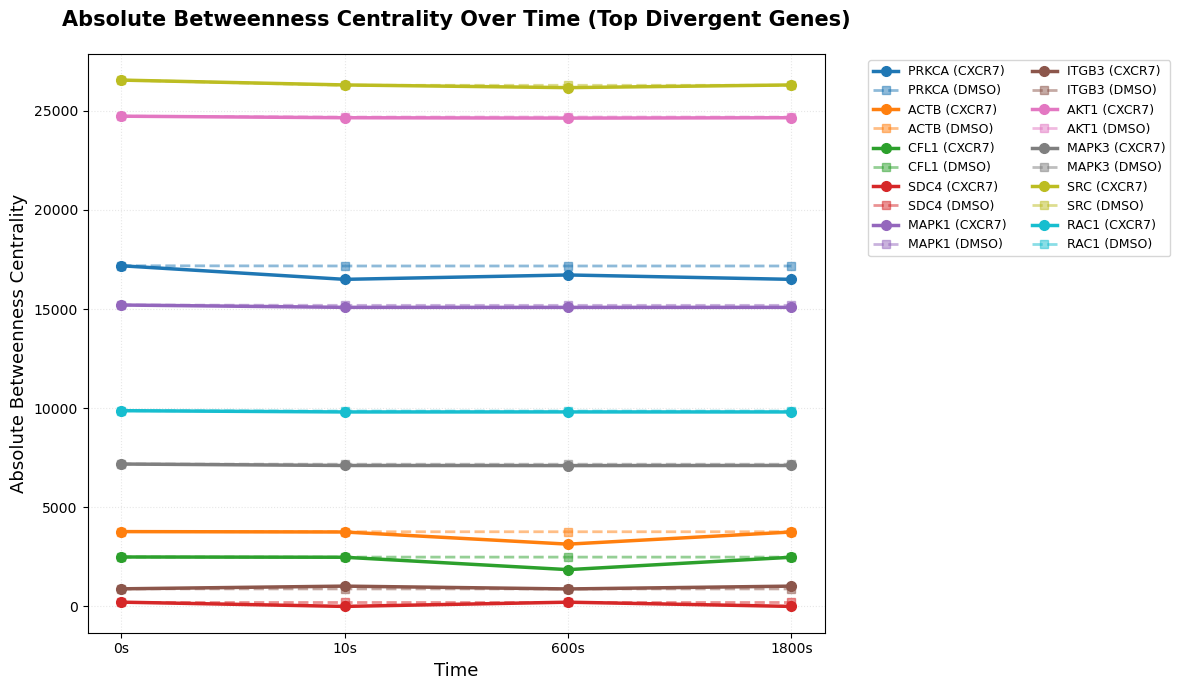

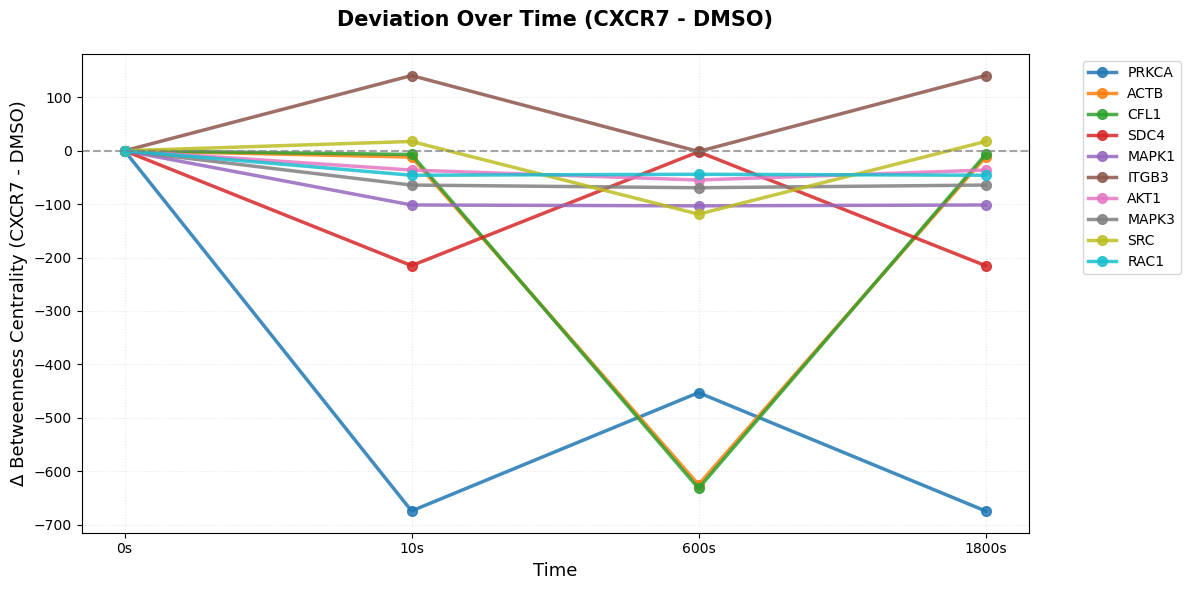


📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)
             Rank uniprot_id                                       phosphosite(s)  dtw_distance  cosine_dissimilarity  euclidean_distance     slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                                                    
PRKCA           1     P17252                P17252;PRKCA;S226;STLNPQWNESFTFK;2646      229.5270                0.0001           1055.8002 -180.1665     0.5353      0.2684       -0.6325         0.3675   -674.3958  decreasing
ACTB            2     P60709        P60709;ACTB;S233;LCYVALDFEQEMATAASSSSLEK;4150       84.0604                0.0027            625.2205  -64.8483     0.0736      0.7287       -0.6325         0.3675    -11.7417  decreasing
CFL1            3     P23528       

In [193]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    """Return pivot (gene × time) for ABSOLUTE betweenness values."""
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0, observed=False)
    return pivot

def cosine_dissimilarity(v1, v2):
    """1 - cosine similarity between two trajectories."""
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Dynamic Time Warping distance between two vectors."""
    alignment = dtw(v1.reshape(-1, 1), v2.reshape(-1, 1))
    return float(alignment.normalizedDistance)

def euclidean_distance(v1, v2):
    """Euclidean distance between two vectors."""
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    """Compute linear regression slope of deviation over time."""
    time_numeric = np.arange(len(deviation_series))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, deviation_series)
    return slope, r_value**2, p_value

def compute_monotonic_trend(deviation_series):
    """Compute Spearman correlation for monotonic trend."""
    time_numeric = np.arange(len(deviation_series))
    rho, p_value = spearmanr(time_numeric, deviation_series)
    return rho, p_value

def directional_change(deviation_series):
    """Net change from first to last timepoint."""
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute ABSOLUTE betweenness trajectories
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}

# Align by common genes
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)
cxcr7_absolute = pivots["CXCR7"].loc[common_genes]
dmso_absolute = pivots["DMSO"].loc[common_genes]

# Rename columns to timepoints for easier alignment
timepoints = ['0s', '10s', '600s', '1800s']
cxcr7_absolute.columns = timepoints
dmso_absolute.columns = timepoints

print(f"\n📊 CXCR7 absolute betweenness shape: {cxcr7_absolute.shape}")
print(f"📊 DMSO absolute betweenness shape: {dmso_absolute.shape}")

# ======================================================
# 🧮 Compute DEVIATION metrics (DTW, Cosine, Euclidean)
# ======================================================
print("\n🔍 Computing deviation metrics for all genes...")

divergence = []
for gene in common_genes:
    v_cxcr7 = np.array(cxcr7_absolute.loc[gene], dtype=float)
    v_dmso = np.array(dmso_absolute.loc[gene], dtype=float)
    
    # Compute divergence metrics
    cos_diff = cosine_dissimilarity(v_cxcr7, v_dmso)
    dtw_diff = dtw_distance(v_cxcr7, v_dmso)
    eucl_diff = euclidean_distance(v_cxcr7, v_dmso)
    
    divergence.append((gene, cos_diff, dtw_diff, eucl_diff))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 🧬 Add phosphosite information (merge by UniProt ID)
# ======================================================
phospho_path = base / "analysis" / "networks" / "prepared_data" / "phospho_intensity.csv"

if phospho_path.exists():
    phospho_df = pd.read_csv(phospho_path)
    phospho_df.columns = [c.lower() for c in phospho_df.columns]

    uniprot_col = next((c for c in phospho_df.columns if "uniprot" in c or "accession" in c or "protein" in c), None)
    gene_col = next((c for c in phospho_df.columns if "gene" in c), None)
    site_col = next((c for c in phospho_df.columns if "site" in c or "position" in c or "residue" in c), None)

    if uniprot_col and gene_col:
        subset_cols = [c for c in [gene_col, uniprot_col, site_col] if c]
        phospho_map = phospho_df[subset_cols].drop_duplicates()

        if site_col:
            phospho_map = (
                phospho_map.groupby([gene_col, uniprot_col])[site_col]
                .apply(lambda x: ";".join(sorted(set(x.dropna().astype(str)))))
                .reset_index()
                .rename(columns={site_col: "phosphosite(s)", gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            )
        else:
            phospho_map = phospho_map.rename(columns={gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            phospho_map["phosphosite(s)"] = np.nan

        if "uniprot_id" in metrics.columns:
            gene_to_uniprot = metrics[["gene_symbol", "uniprot_id"]].drop_duplicates()
        else:
            gene_to_uniprot = phospho_map[["gene_symbol", "uniprot_id"]].drop_duplicates()

        divergence_df = (
            divergence_df.reset_index()
            .merge(gene_to_uniprot, on="gene_symbol", how="left")
            .merge(phospho_map[["uniprot_id", "phosphosite(s)"]], on="uniprot_id", how="left")
            .set_index("gene_symbol")
        )

        front_cols = ["uniprot_id", "phosphosite(s)"]
        divergence_df = divergence_df[[*front_cols, *[c for c in divergence_df.columns if c not in front_cols]]]

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 10
top_genes = divergence_df.head(N_TOP).index
delta_absolute = cxcr7_absolute.loc[top_genes] - dmso_absolute.loc[top_genes]

# ======================================================
# 📈 Compute temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_absolute.loc[gene]
    slope, r2, p_val = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net_change = directional_change(dev_series)
    trend_direction = 'increasing' if slope > 0 else ('decreasing' if slope < 0 else 'stable')
    trend_metrics.append({
        'gene_symbol': gene, 'slope': slope, 'r_squared': r2, 'slope_pval': p_val,
        'spearman_rho': rho, 'spearman_pval': rho_p, 'net_change': net_change, 'trend': trend_direction
    })
trend_df = pd.DataFrame(trend_metrics).set_index('gene_symbol')

# ======================================================
# 🎨 PLOT 1: Absolute betweenness centrality (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

fig, ax = plt.subplots(figsize=(12, 7))

for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    
    # CXCR7: solid line, full color
    ax.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    
    # DMSO: dashed line, lighter shade
    ax.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)

ax.set_title("Absolute Betweenness Centrality Over Time (Top Divergent Genes)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Absolute Betweenness Centrality", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 🎨 PLOT 2: Deviation over time (CXCR7 - DMSO)
# ======================================================
fig, ax = plt.subplots(figsize=(12, 6))

for idx, gene in enumerate(top_genes):
    ax.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)

ax.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax.set_title("Deviation Over Time (CXCR7 - DMSO)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 📊 COMBINED DEVIATION & TREND METRICS TABLES
# ======================================================

# Merge all data
combined_full = divergence_df.join(trend_df).round(4)

# Define column order
optional_cols = [c for c in ['uniprot_id', 'phosphosite(s)'] if c in combined_full.columns]
column_order = ['Rank'] + optional_cols + [
    'dtw_distance', 'cosine_dissimilarity', 'euclidean_distance',
    'slope', 'r_squared', 'slope_pval', 'spearman_rho', 'spearman_pval',
    'net_change', 'trend'
]

# ======================================================
# 📊 TABLE 1: Top genes by DTW distance
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)")
print("="*80)

combined_dtw = combined_full.sort_values('dtw_distance', ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, 'Rank', range(1, len(combined_dtw) + 1))
combined_dtw = combined_dtw[[c for c in column_order if c in combined_dtw.columns]]

print(combined_dtw.to_string())
print("="*80)

# ======================================================
# 📊 TABLE 2: Top genes by POSITIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Deviation)")
print("="*80)

combined_pos = combined_full[combined_full['net_change'] > 0].sort_values('net_change', ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, 'Rank', range(1, len(combined_pos) + 1))
    combined_pos = combined_pos[[c for c in column_order if c in combined_pos.columns]]
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found in top results.")
print("="*80)

# ======================================================
# 📊 TABLE 3: Top genes by NEGATIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Deviation)")
print("="*80)

combined_neg = combined_full[combined_full['net_change'] < 0].sort_values('net_change', ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, 'Rank', range(1, len(combined_neg) + 1))
    combined_neg = combined_neg[[c for c in column_order if c in combined_neg.columns]]
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found in top results.")
print("="*80)

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_absolute_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7_absolute.to_csv(out_dir / "cxcr7_absolute.csv")
dmso_absolute.to_csv(out_dir / "dmso_absolute.csv")
delta_absolute.to_csv(out_dir / "cxcr7_dmso_delta_absolute.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")

# Save all three tables
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

# Save plots
fig1, ax1 = plt.subplots(figsize=(12, 7))
for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    ax1.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    ax1.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)
ax1.set_title("Absolute Betweenness Centrality Over Time (Top Divergent Genes)", 
             fontsize=15, fontweight='bold', pad=20)
ax1.set_xlabel("Time", fontsize=13)
ax1.set_ylabel("Absolute Betweenness Centrality", fontsize=13)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax1.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "absolute_betweenness_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, gene in enumerate(top_genes):
    ax2.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)
ax2.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax2.set_title("Deviation Over Time (CXCR7 - DMSO)", 
             fontsize=15, fontweight='bold', pad=20)
ax2.set_xlabel("Time", fontsize=13)
ax2.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=13)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax2.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "deviation_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ All results saved to: {out_dir}")
print(f"   📄 Data files:")
print(f"      - cxcr7_absolute.csv, dmso_absolute.csv")
print(f"      - cxcr7_dmso_delta_absolute.csv")
print(f"      - trajectory_deviation_metrics.csv")
print(f"      - temporal_trend_metrics.csv")
print(f"      - top_genes_by_dtw.csv (sorted by DTW distance)")
print(f"      - top_genes_positive_netchange.csv (increasing deviation)")
print(f"      - top_genes_negative_netchange.csv (decreasing deviation)")
print(f"   📊 Plot files:")
print(f"      - absolute_betweenness_trajectories.png")
print(f"      - deviation_trajectories.png")

### 5.1.2 Relative betweeness centrality changes - normalized to baseline

Loaded betweenness metrics: (3835, 8)

🧮 Computing log2 fold-change relative to 0s baseline...
   CXCR7 log2FC shape: (549, 4)
   DMSO log2FC shape:  (549, 4)

🔍 Computing trajectory dissimilarity metrics (log2FC)...


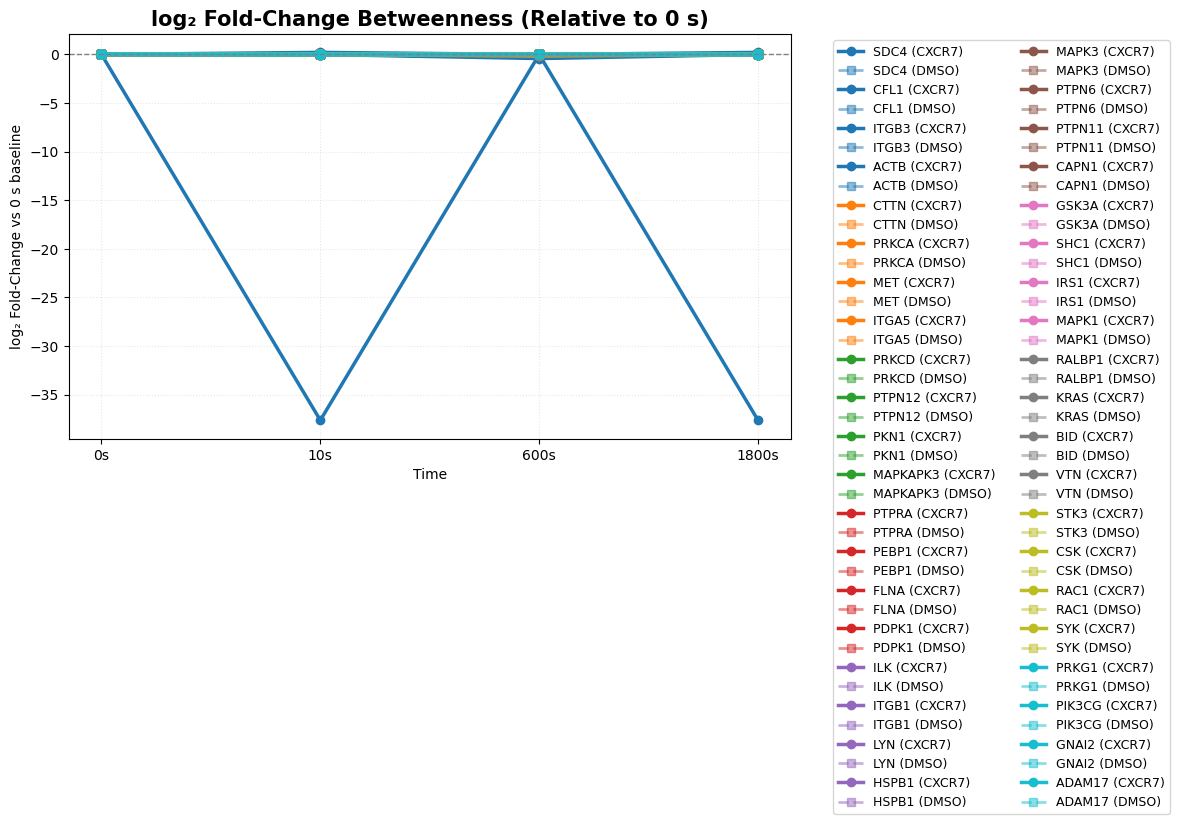

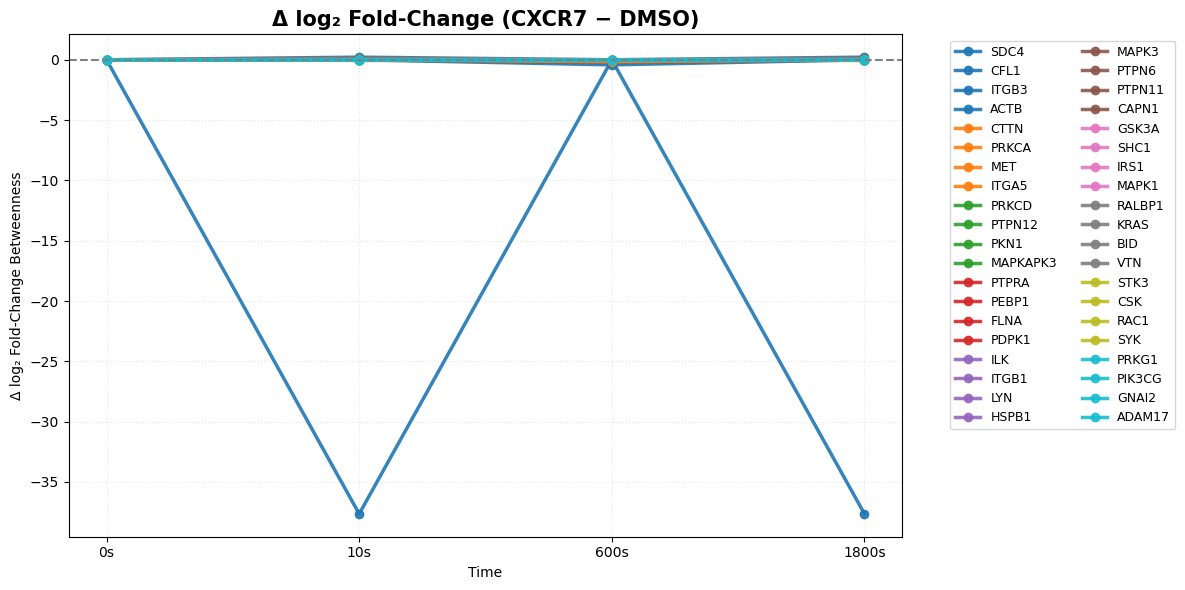


📊 TOP GENES BY DTW DISTANCE (Relative log2FC trajectories)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance  AUC_absDelta  mean_absDelta   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                               
SDC4            1                   NaN        9.4132             53.2397       56.4823        18.8263 -7.5305     0.2001      0.5526       -0.6325         0.3675    -37.6462  decreasing
CFL1            2                0.4024        0.0552              0.4230        0.4291         0.1078 -0.0431     0.0701      0.7352       -0.6325         0.3675     -0.0041  decreasing
ITGB3           3                1.7984        0.0536              0.3021        0.3226         0.1073  0.0425     0.1959      0.5573        0.2108         0.7892      0.2136  increasing
ACTB 

In [199]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")
metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ['0s', '10s', '600s', '1800s']

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network",
                          values="betweenness", fill_value=0, observed=False)

def log2_fold_change(pivot, pseudocount=1e-9):
    """Return log2 fold-change relative to baseline (0s), with pseudocount for stability."""
    baseline = pivot.iloc[:, 0]
    lfc = np.log2((pivot + pseudocount).div(baseline + pseudocount, axis=0))
    lfc.columns = timepoints
    return lfc

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Safe DTW distance with NaN/Inf handling."""
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    t = np.arange(len(deviation_series))
    slope, intercept, r, p, se = linregress(t, deviation_series)
    return slope, r**2, p

def compute_monotonic_trend(deviation_series):
    t = np.arange(len(deviation_series))
    rho, p = spearmanr(t, deviation_series)
    return rho, p

def directional_change(deviation_series):
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute RELATIVE (log2FC) betweenness trajectories
# ======================================================
print("\n🧮 Computing log2 fold-change relative to 0s baseline...")

pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cxcr7_lfc = log2_fold_change(pivots["CXCR7"].loc[common_genes])
dmso_lfc  = log2_fold_change(pivots["DMSO"].loc[common_genes])

print(f"   CXCR7 log2FC shape: {cxcr7_lfc.shape}")
print(f"   DMSO log2FC shape:  {dmso_lfc.shape}")

# ======================================================
# 🧮 Compute RELATIVE DEVIATION (CXCR7 − DMSO)
# ======================================================
delta_lfc = cxcr7_lfc - dmso_lfc

print("\n🔍 Computing trajectory dissimilarity metrics (log2FC)...")

divergence = []
for gene in common_genes:
    v_cx = np.array(cxcr7_lfc.loc[gene], dtype=float)
    v_dm = np.array(dmso_lfc.loc[gene], dtype=float)

    cos_diff = cosine_dissimilarity(v_cx, v_dm)
    dtw_diff = dtw_distance(v_cx, v_dm)
    eucl_diff = euclidean_distance(v_cx, v_dm)
    auc = np.trapezoid(np.abs(v_cx - v_dm))
    mean_diff = np.mean(np.abs(v_cx - v_dm))

    divergence.append((gene, cos_diff, dtw_diff, eucl_diff, auc, mean_diff))

divergence_df = (
    pd.DataFrame(divergence,
        columns=["gene_symbol","cosine_dissimilarity","dtw_distance",
                 "euclidean_distance","AUC_absDelta","mean_absDelta"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

# ======================================================
# 📈 Temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_lfc.loc[gene]
    slope, r2, p = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net = directional_change(dev_series)
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rho_p,
        "net_change": net, "trend": "increasing" if slope>0 else
                     ("decreasing" if slope<0 else "stable")
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")

# ======================================================
# 🎨 PLOT 1: log2FC trajectories (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7_lfc.loc[g], "-o", lw=2.5, color=c,
            label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso_lfc.loc[g], "--s", lw=2, color=c,
            alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title("log₂ Fold-Change Betweenness (Relative to 0 s)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("log₂ Fold-Change vs 0 s baseline")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout(); plt.show()

# ======================================================
# 🎨 PLOT 2: Δlog2FC = CXCR7 − DMSO
# ======================================================
fig, ax = plt.subplots(figsize=(12,6))
for i,g in enumerate(top_genes):
    ax.plot(timepoints, delta_lfc.loc[g], "-o", lw=2.5,
            color=colors[i], alpha=0.9, label=g)
ax.axhline(0, color="gray", ls="--", lw=1.5)
ax.set_title("Δ log₂ Fold-Change (CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("Δ log₂ Fold-Change Betweenness")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout(); plt.show()

# ======================================================
# 📊 Combine metrics
# ======================================================
combined = divergence_df.join(trend_df).round(4)
combined.insert(0,"Rank", range(1,len(combined)+1))
print("\n📊 TOP GENES BY DTW DISTANCE (Relative log2FC trajectories)")
print(combined.head(N_TOP).to_string())

# ======================================================
# 💾 Save
# ======================================================
out_dir = in_dir / "betweenness_relative_log2FC"
out_dir.mkdir(exist_ok=True)
cxcr7_lfc.to_csv(out_dir/"cxcr7_log2fc.csv")
dmso_lfc.to_csv(out_dir/"dmso_log2fc.csv")
delta_lfc.to_csv(out_dir/"delta_log2fc.csv")
divergence_df.to_csv(out_dir/"trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir/"temporal_trend_metrics.csv")
combined.head(N_TOP).to_csv(out_dir/"top_genes_by_dtw.csv")

print(f"\n✅ Results saved to {out_dir}")


Loaded betweenness metrics: (3835, 8)

📊 Absolute betweenness shapes:
   CXCR7: (549, 4)
   DMSO: (549, 4)

🔄 Computing relative betweenness (normalized to t=0)...
✅ Relative betweenness computed (values = % change from baseline)
   CXCR7 relative: (549, 4)
   DMSO relative: (549, 4)

🔍 Computing deviation metrics for all genes...


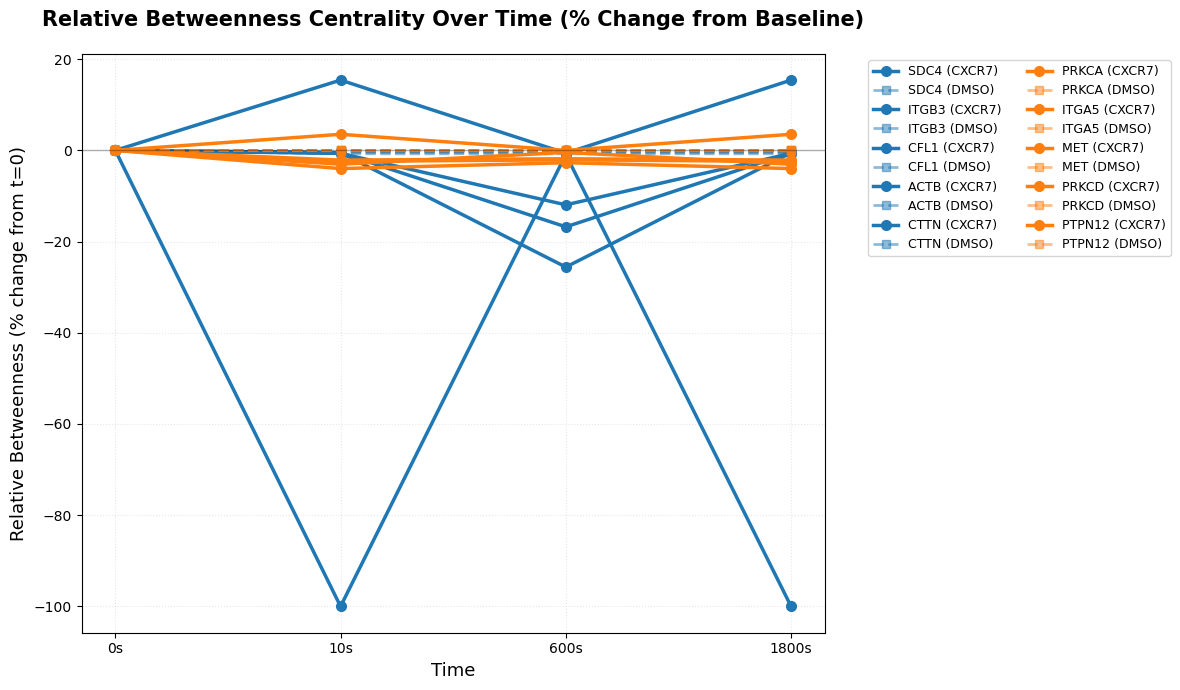

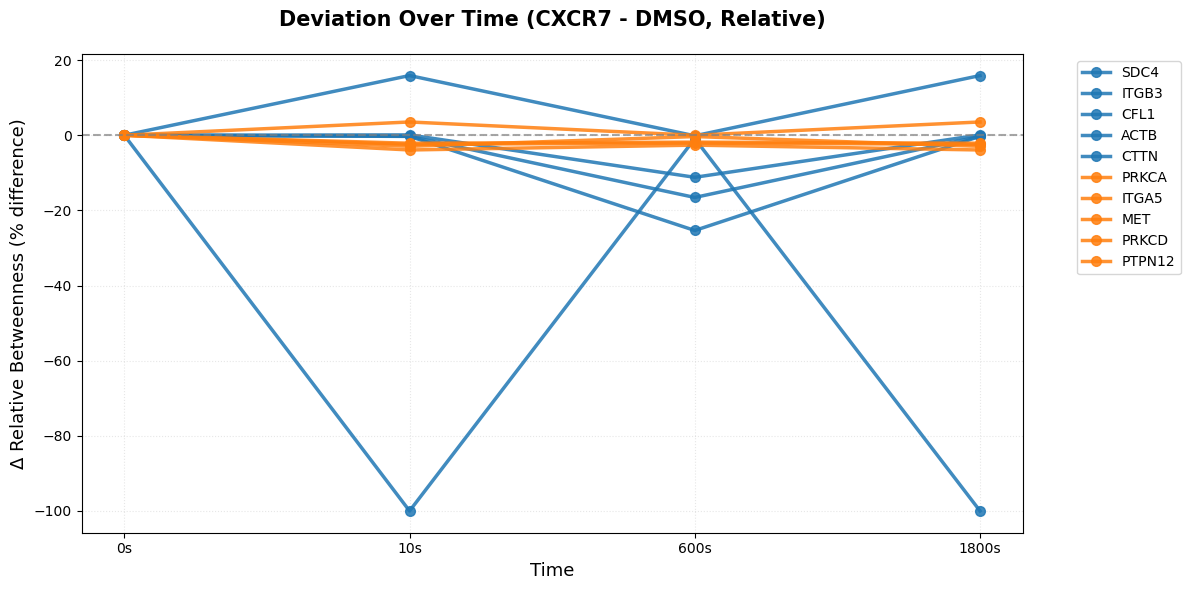


📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)
             Rank uniprot_id                                                phosphosite(s)  dtw_distance  cosine_dissimilarity  euclidean_distance   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                                                           
SDC4            1     P31431                                                           NaN        0.2511                   NaN              1.4142 -0.2009     0.2036      0.5488       -0.6325         0.3675     -1.0000  decreasing
ITGB3           2     P05106                             P05106;ITGB3;T767;WDTANNPLYK;1767        0.0399                1.7997              0.2246  0.0316     0.1962      0.5570        0.2108         0.7892      0.1588  increasing
CFL1   

In [186]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    """Return pivot (gene × time) for betweenness values."""
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0, observed=False)
    return pivot

def normalize_to_baseline(pivot, baseline_col):
    """
    Normalize betweenness relative to baseline (t=0).
    Formula: relative_betweenness = (value - baseline) / baseline
    Returns percentage change from baseline.
    """
    baseline = pivot[baseline_col]
    
    # Avoid division by zero - set baseline to 1 where it's 0
    baseline_safe = baseline.replace(0, 1)
    
    # Calculate relative change
    relative = pivot.div(baseline_safe, axis=0) - 1  # -1 to get % change
    
    return relative

def cosine_dissimilarity(v1, v2):
    """1 - cosine similarity between two trajectories."""
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Dynamic Time Warping distance between two vectors."""
    alignment = dtw(v1.reshape(-1, 1), v2.reshape(-1, 1))
    return float(alignment.normalizedDistance)

def euclidean_distance(v1, v2):
    """Euclidean distance between two vectors."""
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    """Compute linear regression slope of deviation over time."""
    time_numeric = np.arange(len(deviation_series))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, deviation_series)
    return slope, r_value**2, p_value

def compute_monotonic_trend(deviation_series):
    """Compute Spearman correlation for monotonic trend."""
    time_numeric = np.arange(len(deviation_series))
    rho, p_value = spearmanr(time_numeric, deviation_series)
    return rho, p_value

def directional_change(deviation_series):
    """Net change from first to last timepoint."""
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute ABSOLUTE betweenness trajectories
# ======================================================
pivots_abs = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}

# Align by common genes
common_genes = pivots_abs["CXCR7"].index.intersection(pivots_abs["DMSO"].index)
cxcr7_absolute = pivots_abs["CXCR7"].loc[common_genes]
dmso_absolute = pivots_abs["DMSO"].loc[common_genes]

print(f"\n📊 Absolute betweenness shapes:")
print(f"   CXCR7: {cxcr7_absolute.shape}")
print(f"   DMSO: {dmso_absolute.shape}")

# ======================================================
# 🔄 Compute RELATIVE betweenness (normalized to baseline)
# ======================================================
print("\n🔄 Computing relative betweenness (normalized to t=0)...")

# Normalize to baseline (0_Ctrl)
cxcr7_relative = normalize_to_baseline(cxcr7_absolute, "0_Ctrl")
dmso_relative = normalize_to_baseline(dmso_absolute, "0_Ctrl")

# Rename columns to timepoints
timepoints = ['0s', '10s', '600s', '1800s']
cxcr7_relative.columns = timepoints
dmso_relative.columns = timepoints

print(f"✅ Relative betweenness computed (values = % change from baseline)")
print(f"   CXCR7 relative: {cxcr7_relative.shape}")
print(f"   DMSO relative: {dmso_relative.shape}")

# ======================================================
# 🧮 Compute DEVIATION metrics (DTW, Cosine, Euclidean)
# ======================================================
print("\n🔍 Computing deviation metrics for all genes...")

divergence = []
for gene in common_genes:
    v_cxcr7 = np.array(cxcr7_relative.loc[gene], dtype=float)
    v_dmso = np.array(dmso_relative.loc[gene], dtype=float)
    
    # Compute divergence metrics
    cos_diff = cosine_dissimilarity(v_cxcr7, v_dmso)
    dtw_diff = dtw_distance(v_cxcr7, v_dmso)
    eucl_diff = euclidean_distance(v_cxcr7, v_dmso)
    
    divergence.append((gene, cos_diff, dtw_diff, eucl_diff))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 🧬 Add phosphosite information (merge by UniProt ID)
# ======================================================
phospho_path = base / "analysis" / "networks" / "prepared_data" / "phospho_intensity.csv"

if phospho_path.exists():
    phospho_df = pd.read_csv(phospho_path)
    phospho_df.columns = [c.lower() for c in phospho_df.columns]

    uniprot_col = next((c for c in phospho_df.columns if "uniprot" in c or "accession" in c or "protein" in c), None)
    gene_col = next((c for c in phospho_df.columns if "gene" in c), None)
    site_col = next((c for c in phospho_df.columns if "site" in c or "position" in c or "residue" in c), None)

    if uniprot_col and gene_col:
        subset_cols = [c for c in [gene_col, uniprot_col, site_col] if c]
        phospho_map = phospho_df[subset_cols].drop_duplicates()

        if site_col:
            phospho_map = (
                phospho_map.groupby([gene_col, uniprot_col])[site_col]
                .apply(lambda x: ";".join(sorted(set(x.dropna().astype(str)))))
                .reset_index()
                .rename(columns={site_col: "phosphosite(s)", gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            )
        else:
            phospho_map = phospho_map.rename(columns={gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            phospho_map["phosphosite(s)"] = np.nan

        if "uniprot_id" in metrics.columns:
            gene_to_uniprot = metrics[["gene_symbol", "uniprot_id"]].drop_duplicates()
        else:
            gene_to_uniprot = phospho_map[["gene_symbol", "uniprot_id"]].drop_duplicates()

        divergence_df = (
            divergence_df.reset_index()
            .merge(gene_to_uniprot, on="gene_symbol", how="left")
            .merge(phospho_map[["uniprot_id", "phosphosite(s)"]], on="uniprot_id", how="left")
            .set_index("gene_symbol")
        )

        front_cols = ["uniprot_id", "phosphosite(s)"]
        divergence_df = divergence_df[[*front_cols, *[c for c in divergence_df.columns if c not in front_cols]]]

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 50
top_genes = divergence_df.head(N_TOP).index
delta_relative = cxcr7_relative.loc[top_genes] - dmso_relative.loc[top_genes]

# ======================================================
# 📈 Compute temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_relative.loc[gene]
    slope, r2, p_val = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net_change = directional_change(dev_series)
    trend_direction = 'increasing' if slope > 0 else ('decreasing' if slope < 0 else 'stable')
    trend_metrics.append({
        'gene_symbol': gene, 'slope': slope, 'r_squared': r2, 'slope_pval': p_val,
        'spearman_rho': rho, 'spearman_pval': rho_p, 'net_change': net_change, 'trend': trend_direction
    })
trend_df = pd.DataFrame(trend_metrics).set_index('gene_symbol')

# ======================================================
# 🎨 PLOT 1: Relative betweenness centrality (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

fig, ax = plt.subplots(figsize=(12, 7))

for idx, gene in enumerate(top_genes[:10]):  # Show only top 10 for readability
    base_color = colors[idx]
    
    # CXCR7: solid line, full color
    ax.plot(timepoints, cxcr7_relative.loc[gene] * 100, "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    
    # DMSO: dashed line, lighter shade
    ax.plot(timepoints, dmso_relative.loc[gene] * 100, "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)

ax.axhline(0, color="black", ls="-", lw=1, alpha=0.3)
ax.set_title("Relative Betweenness Centrality Over Time (% Change from Baseline)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Relative Betweenness (% change from t=0)", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 🎨 PLOT 2: Deviation over time (CXCR7 - DMSO)
# ======================================================
fig, ax = plt.subplots(figsize=(12, 6))

for idx, gene in enumerate(top_genes[:10]):  # Show only top 10 for readability
    ax.plot(timepoints, delta_relative.loc[gene] * 100, "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)

ax.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax.set_title("Deviation Over Time (CXCR7 - DMSO, Relative)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Δ Relative Betweenness (% difference)", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 📊 COMBINED DEVIATION & TREND METRICS TABLES
# ======================================================

# Merge all data
combined_full = divergence_df.join(trend_df).round(4)

# Define column order
optional_cols = [c for c in ['uniprot_id', 'phosphosite(s)'] if c in combined_full.columns]
column_order = ['Rank'] + optional_cols + [
    'dtw_distance', 'cosine_dissimilarity', 'euclidean_distance',
    'slope', 'r_squared', 'slope_pval', 'spearman_rho', 'spearman_pval',
    'net_change', 'trend'
]

# ======================================================
# 📊 TABLE 1: Top genes by DTW distance
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)")
print("="*80)

combined_dtw = combined_full.sort_values('dtw_distance', ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, 'Rank', range(1, len(combined_dtw) + 1))
combined_dtw = combined_dtw[[c for c in column_order if c in combined_dtw.columns]]

print(combined_dtw.to_string())
print("="*80)

# ======================================================
# 📊 TABLE 2: Top genes by POSITIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Deviation)")
print("="*80)

combined_pos = combined_full[combined_full['net_change'] > 0].sort_values('net_change', ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, 'Rank', range(1, len(combined_pos) + 1))
    combined_pos = combined_pos[[c for c in column_order if c in combined_pos.columns]]
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found in top results.")
print("="*80)

# ======================================================
# 📊 TABLE 3: Top genes by NEGATIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Deviation)")
print("="*80)

combined_neg = combined_full[combined_full['net_change'] < 0].sort_values('net_change', ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, 'Rank', range(1, len(combined_neg) + 1))
    combined_neg = combined_neg[[c for c in column_order if c in combined_neg.columns]]
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found in top results.")
print("="*80)

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_relative_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7_relative.to_csv(out_dir / "cxcr7_relative.csv")
dmso_relative.to_csv(out_dir / "dmso_relative.csv")
delta_relative.to_csv(out_dir / "cxcr7_dmso_delta_relative.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")

# Save all three tables
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

# Save plots
fig1, ax1 = plt.subplots(figsize=(12, 7))
for idx, gene in enumerate(top_genes[:10]):
    base_color = colors[idx]
    ax1.plot(timepoints, cxcr7_relative.loc[gene] * 100, "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    ax1.plot(timepoints, dmso_relative.loc[gene] * 100, "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)
ax1.axhline(0, color="black", ls="-", lw=1, alpha=0.3)
ax1.set_title("Relative Betweenness Centrality Over Time (% Change from Baseline)", 
             fontsize=15, fontweight='bold', pad=20)
ax1.set_xlabel("Time", fontsize=13)
ax1.set_ylabel("Relative Betweenness (% change from t=0)", fontsize=13)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax1.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "relative_betweenness_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, gene in enumerate(top_genes[:10]):
    ax2.plot(timepoints, delta_relative.loc[gene] * 100, "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)
ax2.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax2.set_title("Deviation Over Time (CXCR7 - DMSO, Relative)", 
             fontsize=15, fontweight='bold', pad=20)
ax2.set_xlabel("Time", fontsize=13)
ax2.set_ylabel("Δ Relative Betweenness (% difference)", fontsize=13)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax2.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "deviation_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ All results saved to: {out_dir}")
print(f"   📄 Data files:")
print(f"      - cxcr7_relative.csv, dmso_relative.csv")
print(f"      - cxcr7_dmso_delta_relative.csv")
print(f"      - trajectory_deviation_metrics.csv")
print(f"      - temporal_trend_metrics.csv")
print(f"      - top_genes_by_dtw.csv (sorted by DTW distance)")
print(f"      - top_genes_positive_netchange.csv (increasing deviation)")
print(f"      - top_genes_negative_netchange.csv (decreasing deviation)")
print(f"   📊 Plot files:")
print(f"      - relative_betweenness_trajectories.png")
print(f"      - deviation_trajectories.png")
print(f"\n📊 Note: All values are relative to baseline (t=0)")
print(f"   Values represent % change: 0.5 = +50%, -0.3 = -30%")

### 5.1.3 Relative betweeness centrality changes - z-score normalized

Loaded betweenness metrics: (3835, 8)
✅ Z-score normalization done (mean=0, std=1 per gene).


/tmp/ipykernel_485052/1511955744.py:39: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)
/tmp/ipykernel_485052/1511955744.py:39: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)


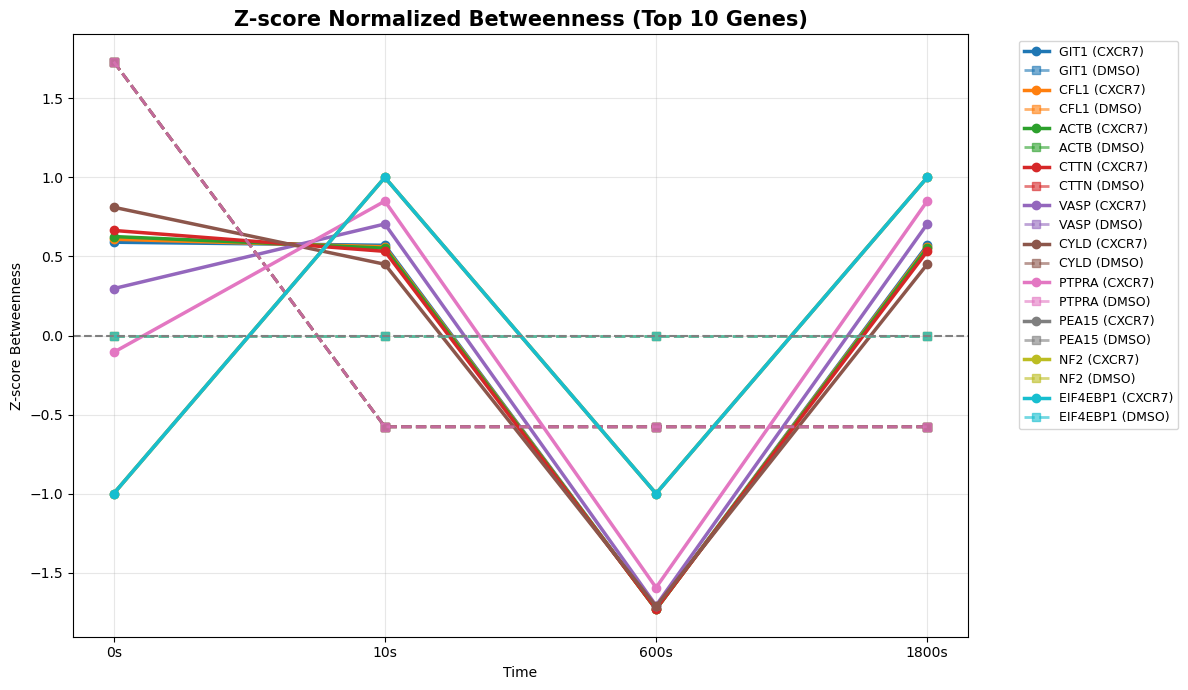

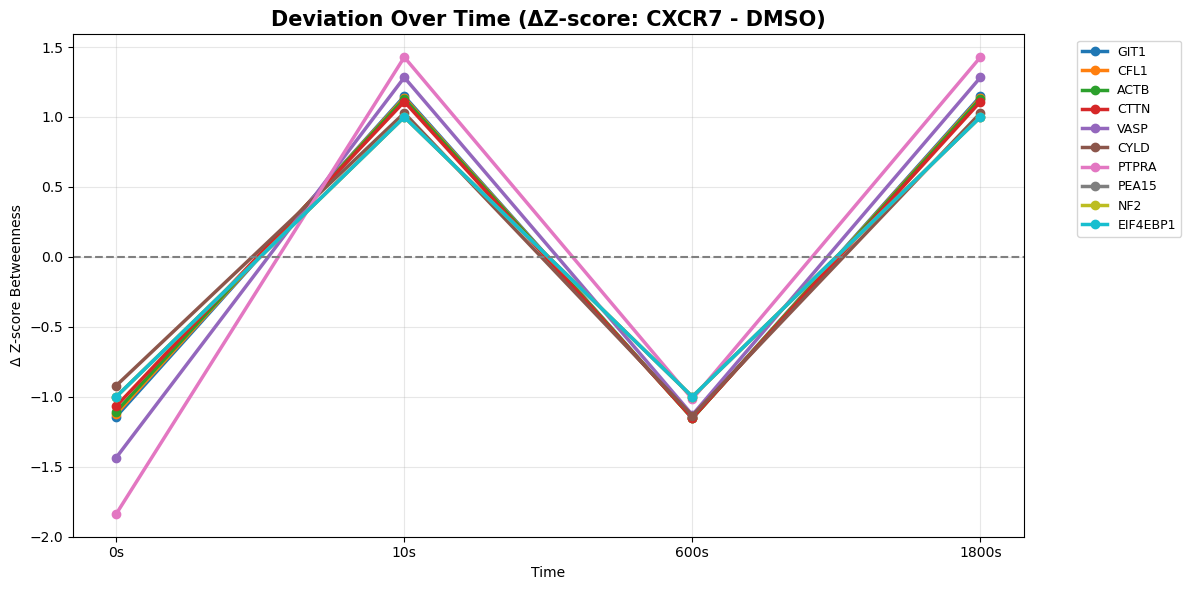


📊 TABLE 1: TOP GENES BY DTW DISTANCE
             Rank uniprot_id                                                phosphosite(s)  dtw_distance  cosine_dissimilarity  euclidean_distance   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                                                           
GIT1            1     Q9Y2X7                          Q9Y2X7;GIT1;S370;SLSSPTDNLELSLR;2285        1.0047                0.6592              2.2965  0.4567     0.1978      0.5553        0.2108         0.7892      2.2900  increasing
CFL1            2     P23528                              P23528;CFL1;S3;ASGVAVSDGVIK;3117        0.9964                0.6484              2.2775  0.4492     0.1945      0.5590        0.2108         0.7892      2.2617  increasing
ACTB            3     P60709          

In [192]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}

timepoints = ["0s", "10s", "600s", "1800s"]

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)

def normalize_zscore(pivot):
    norm = pivot.copy()
    for gene in pivot.index:
        vals = pivot.loc[gene].values
        norm.loc[gene] = (vals - np.mean(vals)) / np.std(vals) if np.std(vals) > 0 else 0
    return norm

def cosine_dissimilarity(v1, v2):
    return float(cosine(v1, v2)) if not (np.all(v1==0) or np.all(v2==0)) else np.nan

def dtw_distance(v1, v2):
    return float(dtw(v1.reshape(-1,1), v2.reshape(-1,1)).normalizedDistance)

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(series):
    x = np.arange(len(series))
    slope, _, r2, p, _ = linregress(x, series)
    return slope, r2**2, p

def compute_monotonic_trend(series):
    x = np.arange(len(series))
    rho, p = spearmanr(x, series)
    return rho, p

def directional_change(series):
    return series.iloc[-1] - series.iloc[0]

# ======================================================
# 🧮 Pivot + normalize
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cxcr7_z = normalize_zscore(pivots["CXCR7"].loc[common_genes])
dmso_z = normalize_zscore(pivots["DMSO"].loc[common_genes])
cxcr7_z.columns = dmso_z.columns = timepoints

print(f"✅ Z-score normalization done (mean=0, std=1 per gene).")

# ======================================================
# 🧮 Compute DEVIATION metrics
# ======================================================
divergence = []
for gene in common_genes:
    v1, v2 = np.array(cxcr7_z.loc[gene]), np.array(dmso_z.loc[gene])
    divergence.append((gene, cosine_dissimilarity(v1, v2), dtw_distance(v1, v2), euclidean_distance(v1, v2)))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 🧬 Add phosphosite info (if available)
# ======================================================
phospho_path = base / "analysis" / "networks" / "prepared_data" / "phospho_intensity.csv"
if phospho_path.exists():
    phospho = pd.read_csv(phospho_path)
    phospho.columns = [c.lower() for c in phospho.columns]
    gcol = next((c for c in phospho.columns if "gene" in c), None)
    ucol = next((c for c in phospho.columns if "uniprot" in c or "accession" in c), None)
    scol = next((c for c in phospho.columns if "site" in c or "position" in c), None)
    if gcol and ucol:
        subset = phospho[[c for c in [gcol, ucol, scol] if c]].drop_duplicates()
        if scol:
            phospho_map = subset.groupby([gcol, ucol])[scol].apply(lambda x: ";".join(sorted(set(x.dropna().astype(str))))).reset_index()
            phospho_map.columns = ["gene_symbol", "uniprot_id", "phosphosite(s)"]
        else:
            phospho_map = subset.rename(columns={gcol:"gene_symbol", ucol:"uniprot_id"})
            phospho_map["phosphosite(s)"] = np.nan
        divergence_df = (
            divergence_df.reset_index()
            .merge(phospho_map, on="gene_symbol", how="left")
            .set_index("gene_symbol")
        )
        divergence_df = divergence_df[[*["uniprot_id", "phosphosite(s)"], *[c for c in divergence_df.columns if c not in ["uniprot_id", "phosphosite(s)"]]]]

# ======================================================
# 📈 Select top genes and compute trend metrics
# ======================================================
N_TOP = 50
top_genes = divergence_df.head(N_TOP).index
delta_z = cxcr7_z.loc[top_genes] - dmso_z.loc[top_genes]

trend_metrics = []
for gene in top_genes:
    s = delta_z.loc[gene]
    slope, r2, p = compute_trend_slope(s)
    rho, rp = compute_monotonic_trend(s)
    net = directional_change(s)
    trend = "increasing" if slope > 0 else ("decreasing" if slope < 0 else "stable")
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2, "slope_pval": p,
        "spearman_rho": rho, "spearman_pval": rp, "net_change": net, "trend": trend
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")
combined_full = divergence_df.join(trend_df).round(4)

# ======================================================
# 🎨 PLOTS
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, min(N_TOP,10)))

# Plot 1: CXCR7 vs DMSO trajectories (Z-score)
fig, ax = plt.subplots(figsize=(12,7))
for idx, gene in enumerate(top_genes[:10]):
    base_c = colors[idx]
    ax.plot(timepoints, cxcr7_z.loc[gene], "-o", lw=2.5, color=base_c, label=f"{gene} (CXCR7)")
    ax.plot(timepoints, dmso_z.loc[gene], "--s", lw=2, color=base_c, alpha=0.6, label=f"{gene} (DMSO)")
ax.axhline(0, color="gray", ls="--")
ax.set_title("Z-score Normalized Betweenness (Top 10 Genes)", fontsize=15, weight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("Z-score Betweenness")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Δ(CXCR7 - DMSO)
fig, ax = plt.subplots(figsize=(12,6))
for idx, gene in enumerate(top_genes[:10]):
    ax.plot(timepoints, delta_z.loc[gene], "-o", lw=2.5, color=colors[idx], label=gene)
ax.axhline(0, color="gray", ls="--")
ax.set_title("Deviation Over Time (ΔZ-score: CXCR7 - DMSO)", fontsize=15, weight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("Δ Z-score Betweenness")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 📊 TABLES 1–3 (console + export)
# ======================================================
column_order = ["Rank", "uniprot_id", "phosphosite(s)",
                "dtw_distance","cosine_dissimilarity","euclidean_distance",
                "slope","r_squared","slope_pval","spearman_rho","spearman_pval",
                "net_change","trend"]

def print_table(title, df):
    print("\n" + "="*80)
    print(title)
    print("="*80)
    print(df.to_string())
    print("="*80)

combined_dtw = combined_full.sort_values("dtw_distance", ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, "Rank", range(1, len(combined_dtw)+1))
combined_dtw = combined_dtw[[c for c in column_order if c in combined_dtw.columns]]
print_table("📊 TABLE 1: TOP GENES BY DTW DISTANCE", combined_dtw)

combined_pos = combined_full[combined_full["net_change"]>0].sort_values("net_change", ascending=False).head(N_TOP).copy()
combined_pos.insert(0, "Rank", range(1, len(combined_pos)+1))
combined_pos = combined_pos[[c for c in column_order if c in combined_pos.columns]]
print_table("📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE", combined_pos)

combined_neg = combined_full[combined_full["net_change"]<0].sort_values("net_change", ascending=True).head(N_TOP).copy()
combined_neg.insert(0, "Rank", range(1, len(combined_neg)+1))
combined_neg = combined_neg[[c for c in column_order if c in combined_neg.columns]]
print_table("📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE", combined_neg)

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_zscore_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7_z.to_csv(out_dir / "cxcr7_zscore.csv")
dmso_z.to_csv(out_dir / "dmso_zscore.csv")
delta_z.to_csv(out_dir / "cxcr7_dmso_delta_zscore.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

print(f"\n✅ All results saved to: {out_dir}")
print("   Includes:")
print("      - Full z-score trajectories")
print("      - Deviation metrics (DTW, cosine, Euclidean)")
print("      - Temporal trend metrics")
print("      - Three top-gene summary tables")
print("      - Plots of trajectories and deviations")


⚙️  CONFIGURATION
   N_CANDIDATES         = 30
   SORT_BY              = combined_score
   WEIGHT_ABSOLUTE      = 0.5
   WEIGHT_ZSCORE        = 0.5
   PRIMARY_METRIC       = dtw_distance
   SAVE_PLOTS           = True
   PLOT_DPI             = 300

📂 Loaded betweenness metrics: (3835, 8)

📊 STEP 1: Computing absolute betweenness trajectories
   CXCR7 shape: (549, 4)
   DMSO shape:  (549, 4)
   Common genes: 549

📊 STEP 2: Z-score normalization for relative dissimilarity
   Z-score normalized trajectories computed

📊 STEP 3: Computing ABSOLUTE dissimilarity metrics
   Absolute dissimilarity computed for 549 genes

📊 STEP 4: Computing RELATIVE (z-score) dissimilarity metrics
   Z-score dissimilarity computed for 549 genes

📊 STEP 5: Combining absolute and relative dissimilarity
   Combined score formula: 0.5*dtw_abs_norm + 0.5*dtw_zscore_norm
   Sorted by: combined_score

✓ Selected top 30 genes

📊 DEVIATION METRICS TABLE (Top Genes)
   Combined scoring: 50% absolute + 50% z-score dissim

,Rank,Combined,DTW_abs,DTW_zscore,Eucl_abs,Eucl_zscore,Cos_abs,Cos_zscore,Mean_CXCR7,Mean_DMSO
gene_symbol,,,,,,,,,,
CFL1,1,0.677,83.000,0.996,632.080,2.277,0.007,0.648,2327.000,2488.500
ACTB,2,0.675,84.060,0.989,625.220,2.260,0.003,0.638,3605.560,3767.680
PRKCA,3,0.613,229.527,0.227,1055.800,0.655,0.000,0.054,16725.900,17176.320
SDC4,4,0.551,54.014,0.872,304.200,2.000,0.293,nan,107.070,215.100
CTTN,5,0.530,21.562,0.971,166.140,2.220,0.001,0.616,1434.290,1475.190
ITGB3,6,0.503,35.348,0.856,199.140,3.526,0.003,1.554,953.460,883.390
GIT1,7,0.500,0.036,1.005,0.400,2.296,0.000,0.659,155.900,155.760
VASP,8,0.483,0.243,0.969,0.910,2.575,0.000,0.829,198.240,198.010
CYLD,9,0.448,0.042,0.900,0.400,2.062,0.000,0.531,243.980,243.830


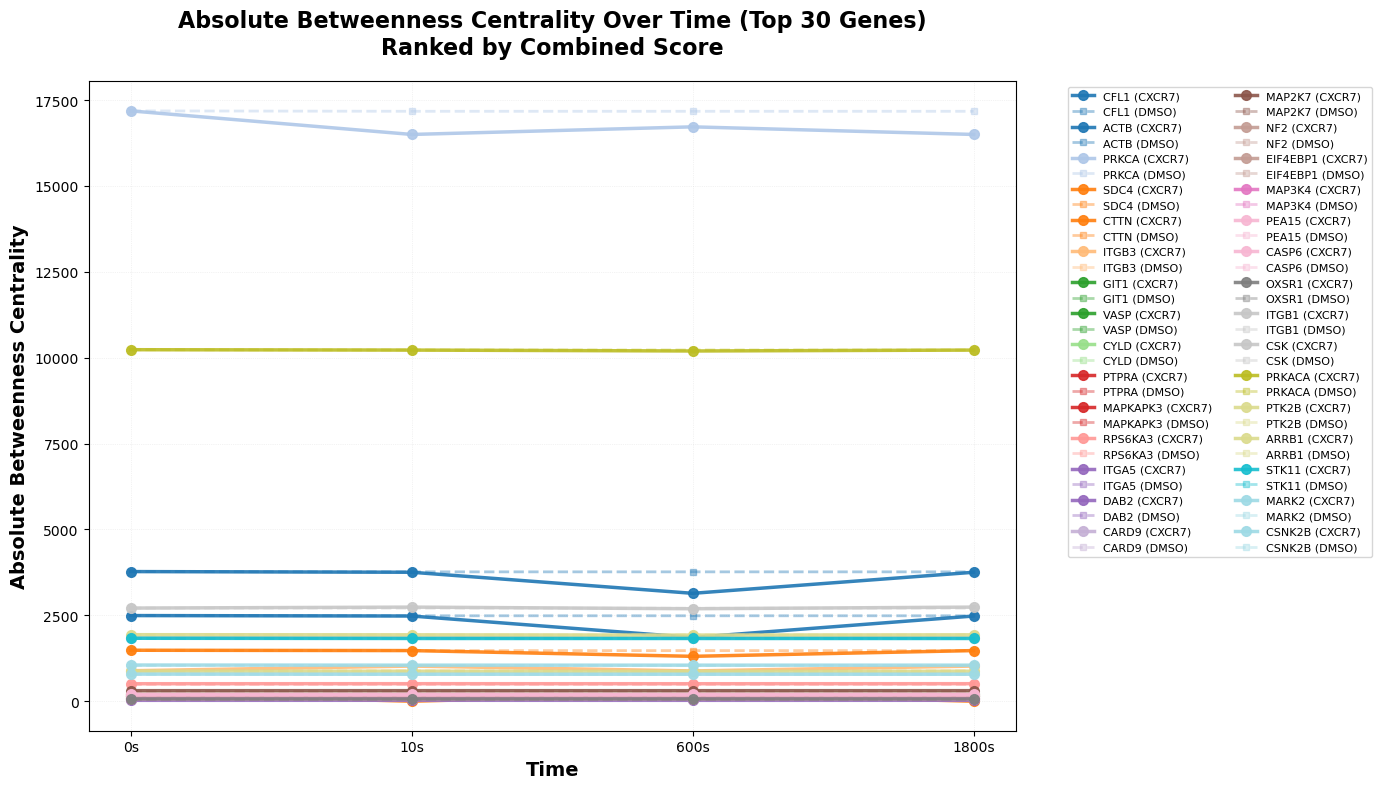

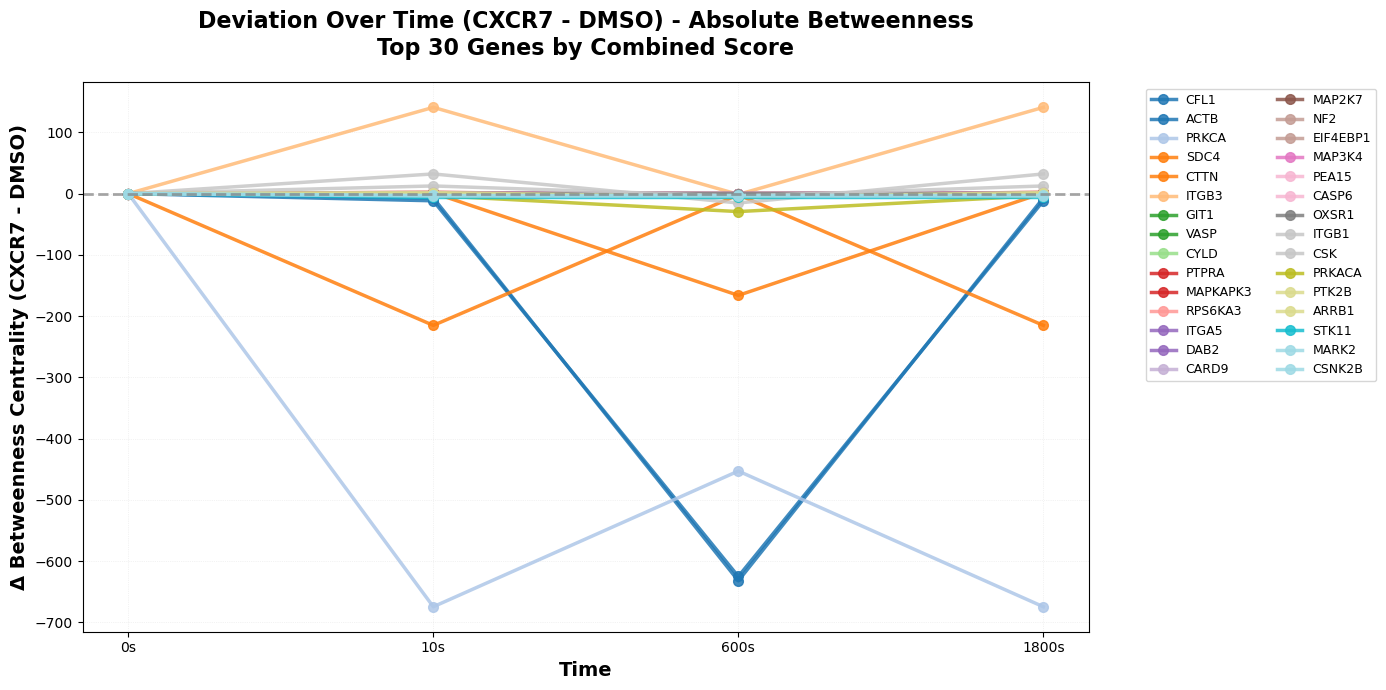

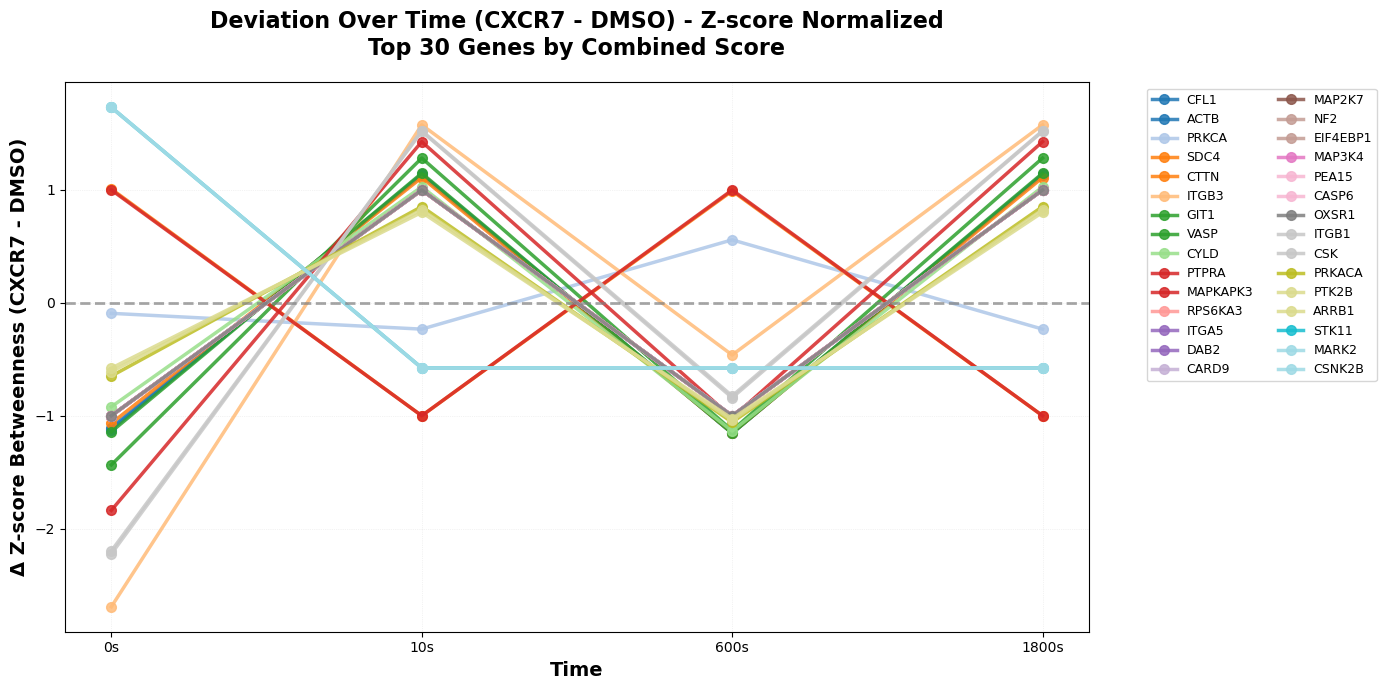


✅ Analysis complete! Results saved to: analysis/networks/subnetworks/betweenness_combined_analysis

📁 Saved files:
   Configuration:
   - analysis_configuration.csv

   Trajectories:
   - cxcr7_absolute.csv, dmso_absolute.csv
   - cxcr7_zscore.csv, dmso_zscore.csv

   Deviations:
   - delta_absolute_top_genes.csv
   - delta_zscore_top_genes.csv

   Metrics:
   - comprehensive_deviation_metrics_all_genes.csv (all 549 genes)
   - top_30_genes_metrics_table.csv

   Plots:
   - plot1_absolute_trajectories_top30.png
   - plot2_deviation_absolute_top30.png
   - plot3_deviation_zscore_top30.png


In [109]:
# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_CANDIDATES': 30,           # Number of top candidates to show in table and plots
    'SORT_BY': 'combined_score',  # Options: 'dtw_distance', 'euclidean_distance', 'cosine_dissimilarity', 'combined_score'
    'WEIGHT_ABSOLUTE': 0.5,       # Weight for absolute dissimilarity (0-1)
    'WEIGHT_ZSCORE': 0.5,         # Weight for z-score dissimilarity (0-1)
    'PRIMARY_METRIC': 'dtw_distance',  # Primary metric for combined score
    'SAVE_PLOTS': True,           # Save plots to disk
    'PLOT_DPI': 300,              # Resolution for saved plots
}

print("="*90)
print("⚙️  CONFIGURATION")
print("="*90)
for key, value in CONFIG.items():
    print(f"   {key:20s} = {value}")
print("="*90)

# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, zscore
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"\n📂 Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    """Return pivot (gene × time) for ABSOLUTE betweenness values."""
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0, observed=False)
    return pivot

def normalize_zscore(pivot):
    """
    Z-score normalize each gene across timepoints.
    Centers mean at 0, scales by standard deviation.
    """
    zscore_norm = pivot.copy()
    for gene in pivot.index:
        values = pivot.loc[gene].values
        if values.std() > 0:
            zscore_norm.loc[gene] = (values - values.mean()) / values.std()
        else:
            zscore_norm.loc[gene] = 0
    return zscore_norm

def cosine_dissimilarity(v1, v2):
    """1 - cosine similarity between two trajectories."""
    try:
        if np.all(v1 == 0) or np.all(v2 == 0) or np.all(v1 == v2):
            return np.nan
        result = cosine(v1, v2)
        return float(result) if not np.isnan(result) else np.nan
    except:
        return np.nan

def dtw_distance(v1, v2):
    """Dynamic Time Warping distance between two vectors."""
    alignment = dtw(v1.reshape(-1, 1), v2.reshape(-1, 1))
    return float(alignment.normalizedDistance)

def euclidean_distance(v1, v2):
    """Euclidean distance between two vectors."""
    return float(np.linalg.norm(v1 - v2))

# ======================================================
# 🧮 Step 1: Compute ABSOLUTE betweenness trajectories
# ======================================================
print("\n" + "="*90)
print("📊 STEP 1: Computing absolute betweenness trajectories")
print("="*90)

pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}

# Align by common genes
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)
cxcr7_absolute = pivots["CXCR7"].loc[common_genes]
dmso_absolute = pivots["DMSO"].loc[common_genes]

# Rename columns to timepoints
timepoints = ['0s', '10s', '600s', '1800s']
cxcr7_absolute.columns = timepoints
dmso_absolute.columns = timepoints

print(f"   CXCR7 shape: {cxcr7_absolute.shape}")
print(f"   DMSO shape:  {dmso_absolute.shape}")
print(f"   Common genes: {len(common_genes)}")

# ======================================================
# 🧮 Step 2: Z-score normalize for relative comparison
# ======================================================
print("\n" + "="*90)
print("📊 STEP 2: Z-score normalization for relative dissimilarity")
print("="*90)

cxcr7_zscore = normalize_zscore(cxcr7_absolute)
dmso_zscore = normalize_zscore(dmso_absolute)

print(f"   Z-score normalized trajectories computed")

# ======================================================
# 🧮 Step 3: Compute ABSOLUTE dissimilarity
# ======================================================
print("\n" + "="*90)
print("📊 STEP 3: Computing ABSOLUTE dissimilarity metrics")
print("="*90)

divergence_absolute = []
for gene in common_genes:
    v_cxcr7 = np.array(cxcr7_absolute.loc[gene], dtype=float)
    v_dmso = np.array(dmso_absolute.loc[gene], dtype=float)
    
    cos_diff = cosine_dissimilarity(v_cxcr7, v_dmso)
    dtw_diff = dtw_distance(v_cxcr7, v_dmso)
    eucl_diff = euclidean_distance(v_cxcr7, v_dmso)
    
    divergence_absolute.append((gene, cos_diff, dtw_diff, eucl_diff))

divergence_absolute_df = pd.DataFrame(
    divergence_absolute, 
    columns=["gene_symbol", "cosine_abs", "dtw_abs", "euclidean_abs"]
).set_index("gene_symbol")

print(f"   Absolute dissimilarity computed for {len(divergence_absolute)} genes")

# ======================================================
# 🧮 Step 4: Compute RELATIVE (Z-score) dissimilarity
# ======================================================
print("\n" + "="*90)
print("📊 STEP 4: Computing RELATIVE (z-score) dissimilarity metrics")
print("="*90)

divergence_zscore = []
for gene in common_genes:
    v_cxcr7 = np.array(cxcr7_zscore.loc[gene], dtype=float)
    v_dmso = np.array(dmso_zscore.loc[gene], dtype=float)
    
    cos_diff = cosine_dissimilarity(v_cxcr7, v_dmso)
    dtw_diff = dtw_distance(v_cxcr7, v_dmso)
    eucl_diff = euclidean_distance(v_cxcr7, v_dmso)
    
    divergence_zscore.append((gene, cos_diff, dtw_diff, eucl_diff))

divergence_zscore_df = pd.DataFrame(
    divergence_zscore, 
    columns=["gene_symbol", "cosine_zscore", "dtw_zscore", "euclidean_zscore"]
).set_index("gene_symbol")

print(f"   Z-score dissimilarity computed for {len(divergence_zscore)} genes")

# ======================================================
# 🧮 Step 5: Combine metrics
# ======================================================
print("\n" + "="*90)
print("📊 STEP 5: Combining absolute and relative dissimilarity")
print("="*90)

# Merge both dissimilarity dataframes
divergence_combined = divergence_absolute_df.join(divergence_zscore_df)

# Normalize metrics to 0-1 scale for fair combination
def normalize_column(series):
    """Min-max normalize to [0, 1], handling NaN values."""
    valid_vals = series.dropna()
    if len(valid_vals) == 0 or valid_vals.max() == valid_vals.min():
        return pd.Series(0, index=series.index)
    normalized = (series - valid_vals.min()) / (valid_vals.max() - valid_vals.min())
    return normalized

# Normalize each metric
for col in divergence_combined.columns:
    divergence_combined[f'{col}_norm'] = normalize_column(divergence_combined[col])

# Compute combined score based on primary metric
primary = CONFIG['PRIMARY_METRIC']
w_abs = CONFIG['WEIGHT_ABSOLUTE']
w_zscore = CONFIG['WEIGHT_ZSCORE']

# Map primary metric to column names
metric_map = {
    'dtw_distance': ('dtw_abs_norm', 'dtw_zscore_norm'),
    'euclidean_distance': ('euclidean_abs_norm', 'euclidean_zscore_norm'),
    'cosine_dissimilarity': ('cosine_abs_norm', 'cosine_zscore_norm')
}

abs_col, zscore_col = metric_map[primary]

divergence_combined['combined_score'] = (
    w_abs * divergence_combined[abs_col].fillna(0) + 
    w_zscore * divergence_combined[zscore_col].fillna(0)
)

# Add mean absolute betweenness for context
divergence_combined['mean_abs_cxcr7'] = cxcr7_absolute.mean(axis=1)
divergence_combined['mean_abs_dmso'] = dmso_absolute.mean(axis=1)

# Sort by selected metric
divergence_combined = divergence_combined.sort_values(CONFIG['SORT_BY'], ascending=False)

print(f"   Combined score formula: {w_abs}*{abs_col} + {w_zscore}*{zscore_col}")
print(f"   Sorted by: {CONFIG['SORT_BY']}")

# ======================================================
# 📈 Step 6: Select top candidates
# ======================================================
N_TOP = CONFIG['N_CANDIDATES']
top_genes = divergence_combined.head(N_TOP).index

print(f"\n✓ Selected top {N_TOP} genes")

# Compute deviations
delta_absolute = cxcr7_absolute.loc[top_genes] - dmso_absolute.loc[top_genes]
delta_zscore = cxcr7_zscore.loc[top_genes] - dmso_zscore.loc[top_genes]

# ======================================================
# 📊 TABLE: Comprehensive deviation metrics
# ======================================================
print("\n" + "="*100)
print("📊 DEVIATION METRICS TABLE (Top Genes)")
print(f"   Combined scoring: {w_abs*100:.0f}% absolute + {w_zscore*100:.0f}% z-score dissimilarity")
print("="*100)

# Create display table with key metrics
display_table = pd.DataFrame(index=top_genes)
display_table['Rank'] = range(1, N_TOP + 1)

# Absolute metrics
display_table['DTW_abs'] = divergence_combined.loc[top_genes, 'dtw_abs'].round(4)
display_table['Eucl_abs'] = divergence_combined.loc[top_genes, 'euclidean_abs'].round(2)
display_table['Cos_abs'] = divergence_combined.loc[top_genes, 'cosine_abs'].round(4)

# Z-score metrics
display_table['DTW_zscore'] = divergence_combined.loc[top_genes, 'dtw_zscore'].round(4)
display_table['Eucl_zscore'] = divergence_combined.loc[top_genes, 'euclidean_zscore'].round(4)
display_table['Cos_zscore'] = divergence_combined.loc[top_genes, 'cosine_zscore'].round(4)

# Combined score
display_table['Combined'] = divergence_combined.loc[top_genes, 'combined_score'].round(4)

# Mean absolute betweenness
display_table['Mean_CXCR7'] = divergence_combined.loc[top_genes, 'mean_abs_cxcr7'].round(2)
display_table['Mean_DMSO'] = divergence_combined.loc[top_genes, 'mean_abs_dmso'].round(2)

# Reorder columns
display_table = display_table[['Rank', 'Combined', 'DTW_abs', 'DTW_zscore', 
                               'Eucl_abs', 'Eucl_zscore', 'Cos_abs', 'Cos_zscore',
                               'Mean_CXCR7', 'Mean_DMSO']]

print(display_table.to_string())
print("="*100)

# Styled display for Jupyter
styled_table = display_table.style\
    .background_gradient(subset=['Combined'], cmap='Reds')\
    .background_gradient(subset=['DTW_abs', 'DTW_zscore'], cmap='Blues')\
    .format(precision=3)
display(styled_table)

# ======================================================
# 🎨 PLOT 1: Absolute betweenness centrality over time
# ======================================================
colors = plt.cm.tab20(np.linspace(0, 1, N_TOP))  # Use tab20 for more colors

fig1, ax1 = plt.subplots(figsize=(14, 8))

for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    
    # CXCR7: solid line, full color
    ax1.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7, alpha=0.9)
    
    # DMSO: dashed line, lighter shade
    ax1.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.4, label=f"{gene} (DMSO)", markersize=5)

ax1.set_title(f"Absolute Betweenness Centrality Over Time (Top {N_TOP} Genes)\nRanked by {CONFIG['SORT_BY'].replace('_', ' ').title()}", 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel("Time", fontsize=14, fontweight='bold')
ax1.set_ylabel("Absolute Betweenness Centrality", fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, ncol=2)
ax1.grid(alpha=0.3, ls=":", linewidth=0.5)
plt.tight_layout()
plt.show()

# ======================================================
# 🎨 PLOT 2: Deviation over time (Absolute values)
# ======================================================
fig2, ax2 = plt.subplots(figsize=(14, 7))

for idx, gene in enumerate(top_genes):
    ax2.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)

ax2.axhline(0, color="gray", ls="--", lw=2, alpha=0.7)
ax2.set_title(f"Deviation Over Time (CXCR7 - DMSO) - Absolute Betweenness\nTop {N_TOP} Genes by {CONFIG['SORT_BY'].replace('_', ' ').title()}", 
             fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel("Time", fontsize=14, fontweight='bold')
ax2.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax2.grid(alpha=0.3, ls=":", linewidth=0.5)
plt.tight_layout()
plt.show()

# ======================================================
# 🎨 PLOT 3: Deviation over time (Z-scored values)
# ======================================================
fig3, ax3 = plt.subplots(figsize=(14, 7))

for idx, gene in enumerate(top_genes):
    ax3.plot(timepoints, delta_zscore.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)

ax3.axhline(0, color="gray", ls="--", lw=2, alpha=0.7)
ax3.set_title(f"Deviation Over Time (CXCR7 - DMSO) - Z-score Normalized\nTop {N_TOP} Genes by {CONFIG['SORT_BY'].replace('_', ' ').title()}", 
             fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel("Time", fontsize=14, fontweight='bold')
ax3.set_ylabel("Δ Z-score Betweenness (CXCR7 - DMSO)", fontsize=14, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax3.grid(alpha=0.3, ls=":", linewidth=0.5)
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_combined_analysis"
out_dir.mkdir(exist_ok=True)

# Save all trajectories
cxcr7_absolute.to_csv(out_dir / "cxcr7_absolute.csv")
dmso_absolute.to_csv(out_dir / "dmso_absolute.csv")
cxcr7_zscore.to_csv(out_dir / "cxcr7_zscore.csv")
dmso_zscore.to_csv(out_dir / "dmso_zscore.csv")

# Save deviations
delta_absolute.to_csv(out_dir / "delta_absolute_top_genes.csv")
delta_zscore.to_csv(out_dir / "delta_zscore_top_genes.csv")

# Save comprehensive metrics
divergence_combined.to_csv(out_dir / "comprehensive_deviation_metrics_all_genes.csv")
display_table.to_csv(out_dir / f"top_{N_TOP}_genes_metrics_table.csv")

# Save configuration
config_df = pd.DataFrame([CONFIG])
config_df.to_csv(out_dir / "analysis_configuration.csv", index=False)

# Save plots
if CONFIG['SAVE_PLOTS']:
    dpi = CONFIG['PLOT_DPI']
    fig1.savefig(out_dir / f"plot1_absolute_trajectories_top{N_TOP}.png", dpi=dpi, bbox_inches='tight')
    fig2.savefig(out_dir / f"plot2_deviation_absolute_top{N_TOP}.png", dpi=dpi, bbox_inches='tight')
    fig3.savefig(out_dir / f"plot3_deviation_zscore_top{N_TOP}.png", dpi=dpi, bbox_inches='tight')

print(f"\n{'='*100}")
print(f"✅ Analysis complete! Results saved to: {out_dir}")
print(f"{'='*100}")
print(f"\n📁 Saved files:")
print(f"   Configuration:")
print(f"   - analysis_configuration.csv")
print(f"\n   Trajectories:")
print(f"   - cxcr7_absolute.csv, dmso_absolute.csv")
print(f"   - cxcr7_zscore.csv, dmso_zscore.csv")
print(f"\n   Deviations:")
print(f"   - delta_absolute_top_genes.csv")
print(f"   - delta_zscore_top_genes.csv")
print(f"\n   Metrics:")
print(f"   - comprehensive_deviation_metrics_all_genes.csv (all {len(common_genes)} genes)")
print(f"   - top_{N_TOP}_genes_metrics_table.csv")
print(f"\n   Plots:")
print(f"   - plot1_absolute_trajectories_top{N_TOP}.png")
print(f"   - plot2_deviation_absolute_top{N_TOP}.png")
print(f"   - plot3_deviation_zscore_top{N_TOP}.png")

⚙️  CONFIGURATION
   N_CANDIDATES         = 30
   SORT_BY              = delta_slope
   WEIGHT_ABSOLUTE      = 0.5
   WEIGHT_ZSCORE        = 0.5
   PRIMARY_METRIC       = dtw_distance
   SAVE_PLOTS           = True
   PLOT_DPI             = 300

📂 Loaded betweenness metrics: (3835, 8)

📊 STEP 1: Computing absolute and z-score trajectories
   Common genes: 549

📊 STEP 2: Computing dissimilarities


/tmp/ipykernel_485052/1934902266.py:59: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)
/tmp/ipykernel_485052/1934902266.py:59: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)



📈 STEP 3: Computing trend metrics (slope, Δ, AUC, variance)

📊 EXTENDED DEVIATION & TREND METRICS (Top Genes)
             Rank  Combined  DTW_abs   DTW_z  Slope_CXCR7  Slope_DMSO  ΔSlope       ΔAUC  Δ(1800–0)  Mean_CXCR7  Mean_DMSO
gene_symbol                                                                                                               
ITGB3           1    0.5030  35.3480  0.8561       0.0385     -0.0012  0.0397  125534.54     140.81      953.46     883.39
ITGB1           2    0.4236  11.3829  0.8015       0.0080     -0.0011  0.0091   15203.25      32.12     2720.48    2708.24
SRC             3    0.2214  25.7033  0.3323      -0.0685     -0.0735  0.0050  -90593.20      17.38    26333.41   26354.39
CSK             4    0.4050   4.5240  0.7941       0.0029     -0.0007  0.0035    7675.96      12.51     1847.15    1841.90
PTPRA           5    0.4453   0.9637  0.8906       0.0006     -0.0001  0.0006    -623.87       2.14      163.80     163.44
CTTN            6    0.5302 

/tmp/ipykernel_485052/1934902266.py:85: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time_numeric)
/tmp/ipykernel_485052/1934902266.py:85: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time_numeric)


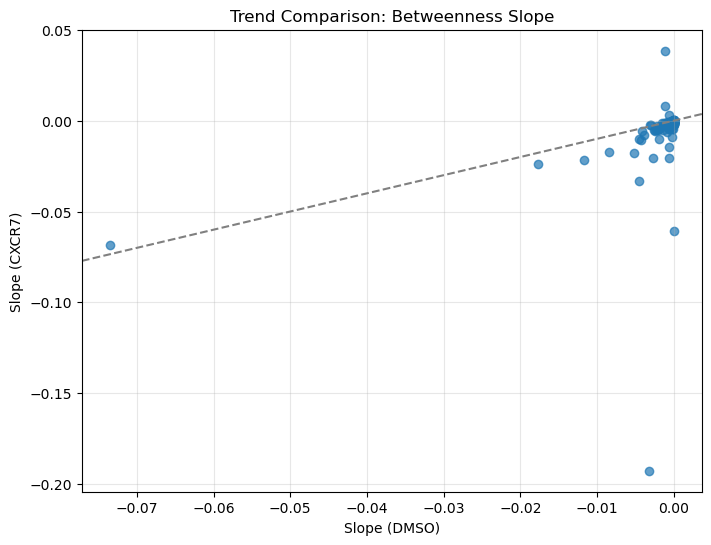


✅ Saved results with trend metrics to analysis/networks/subnetworks/betweenness_trend_analysis


In [110]:
# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_CANDIDATES': 30,              # Number of top candidates to show
    'SORT_BY': 'delta_slope',        # Options: 'combined_score', 'delta_slope', 'delta_auc', etc.
    'WEIGHT_ABSOLUTE': 0.5,          # Weight for absolute dissimilarity (0–1)
    'WEIGHT_ZSCORE': 0.5,            # Weight for z-score dissimilarity (0–1)
    'PRIMARY_METRIC': 'dtw_distance',# Metric for combined score
    'SAVE_PLOTS': True,              # Save plots to disk
    'PLOT_DPI': 300,                 # Resolution for saved plots
}

print("="*90)
print("⚙️  CONFIGURATION")
print("="*90)
for key, value in CONFIG.items():
    print(f"   {key:20s} = {value}")
print("="*90)

# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"\n📂 Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ['0s', '10s', '600s', '1800s']
time_numeric = np.array([0, 10, 600, 1800], dtype=float)

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)
    return pivot

def normalize_zscore(pivot):
    z = pivot.copy()
    for gene in z.index:
        vals = z.loc[gene].values
        z.loc[gene] = (vals - vals.mean()) / vals.std() if vals.std() > 0 else 0
    return z

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0): return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    alignment = dtw(v1.reshape(-1,1), v2.reshape(-1,1))
    return float(alignment.normalizedDistance)

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_metrics(df):
    slopes, aucs, deltas, vars_ = {}, {}, {}, {}
    for g in df.index:
        y = df.loc[g].values.astype(float)
        slope, _, _, _, _ = linregress(time_numeric, y)
        auc = np.trapz(y, time_numeric)
        delta = y[-1] - y[0]
        var = np.var(y)
        slopes[g], aucs[g], deltas[g], vars_[g] = slope, auc, delta, var
    return pd.DataFrame({'slope': slopes, 'auc': aucs, 'delta': deltas, 'variance': vars_})

def normalize_column(s):
    v = s.dropna()
    if len(v) == 0 or v.max() == v.min(): return pd.Series(0, index=s.index)
    return (s - v.min()) / (v.max() - v.min())

# ======================================================
# 🧮 Step 1: Compute trajectories
# ======================================================
print("\n" + "="*90)
print("📊 STEP 1: Computing absolute and z-score trajectories")
print("="*90)

pivots = {k: pivot_betweenness(metrics, v) for k,v in trajectories.items()}
common = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cxcr7_abs = pivots["CXCR7"].loc[common]
dmso_abs = pivots["DMSO"].loc[common]
cxcr7_abs.columns = dmso_abs.columns = timepoints

cxcr7_z = normalize_zscore(cxcr7_abs)
dmso_z = normalize_zscore(dmso_abs)
print(f"   Common genes: {len(common)}")

# ======================================================
# 🧮 Step 2: Compute dissimilarities
# ======================================================
print("\n" + "="*90)
print("📊 STEP 2: Computing dissimilarities")
print("="*90)

def compute_dissim(df1, df2):
    results = []
    for g in common:
        v1, v2 = np.array(df1.loc[g]), np.array(df2.loc[g])
        results.append((g, cosine_dissimilarity(v1,v2), dtw_distance(v1,v2), euclidean_distance(v1,v2)))
    return pd.DataFrame(results, columns=['gene_symbol','cosine','dtw','euclidean']).set_index('gene_symbol')

abs_d = compute_dissim(cxcr7_abs, dmso_abs).add_suffix('_abs')
z_d = compute_dissim(cxcr7_z, dmso_z).add_suffix('_z')

div = abs_d.join(z_d)

for c in div.columns:
    div[c+'_norm'] = normalize_column(div[c])

abs_col, z_col = {
    'dtw_distance': ('dtw_abs_norm','dtw_z_norm'),
    'euclidean_distance': ('euclidean_abs_norm','euclidean_z_norm'),
    'cosine_dissimilarity': ('cosine_abs_norm','cosine_z_norm')
}[CONFIG['PRIMARY_METRIC']]

div['combined_score'] = CONFIG['WEIGHT_ABSOLUTE']*div[abs_col] + CONFIG['WEIGHT_ZSCORE']*div[z_col]

div['mean_abs_cxcr7'] = cxcr7_abs.mean(axis=1)
div['mean_abs_dmso'] = dmso_abs.mean(axis=1)

# ======================================================
# 🧮 Step 3: Compute trend metrics
# ======================================================
print("\n" + "="*90)
print("📈 STEP 3: Computing trend metrics (slope, Δ, AUC, variance)")
print("="*90)

trend_cx = compute_trend_metrics(cxcr7_abs).add_suffix('_CXCR7')
trend_dm = compute_trend_metrics(dmso_abs).add_suffix('_DMSO')
trend = trend_cx.join(trend_dm)

trend['delta_slope'] = trend['slope_CXCR7'] - trend['slope_DMSO']
trend['delta_auc'] = trend['auc_CXCR7'] - trend['auc_DMSO']
trend['delta_delta'] = trend['delta_CXCR7'] - trend['delta_DMSO']

# Merge everything
div_full = div.join(trend)
div_full = div_full.sort_values(CONFIG['SORT_BY'], ascending=False)

# ======================================================
# 📊 Step 4: Display and rank
# ======================================================
N = CONFIG['N_CANDIDATES']
top_genes = div_full.head(N).index

table = pd.DataFrame(index=top_genes)
table['Rank'] = range(1, N+1)
table['Combined'] = div_full.loc[top_genes,'combined_score'].round(4)
table['DTW_abs'] = div_full.loc[top_genes,'dtw_abs'].round(4)
table['DTW_z'] = div_full.loc[top_genes,'dtw_z'].round(4)
table['Slope_CXCR7'] = div_full.loc[top_genes,'slope_CXCR7'].round(4)
table['Slope_DMSO'] = div_full.loc[top_genes,'slope_DMSO'].round(4)
table['ΔSlope'] = div_full.loc[top_genes,'delta_slope'].round(4)
table['ΔAUC'] = div_full.loc[top_genes,'delta_auc'].round(2)
table['Δ(1800–0)'] = div_full.loc[top_genes,'delta_delta'].round(2)
table['Mean_CXCR7'] = div_full.loc[top_genes,'mean_abs_cxcr7'].round(2)
table['Mean_DMSO'] = div_full.loc[top_genes,'mean_abs_dmso'].round(2)

print("\n" + "="*110)
print("📊 EXTENDED DEVIATION & TREND METRICS (Top Genes)")
print("="*110)
print(table.to_string())
print("="*110)

# ======================================================
# 🎨 Plot trends comparison
# ======================================================
plt.figure(figsize=(8,6))
plt.scatter(div_full['slope_DMSO'], div_full['slope_CXCR7'], alpha=0.7)
plt.axline((0,0), slope=1, color='gray', ls='--')
plt.xlabel('Slope (DMSO)')
plt.ylabel('Slope (CXCR7)')
plt.title('Trend Comparison: Betweenness Slope')
plt.grid(alpha=0.3)
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_trend_analysis"
out_dir.mkdir(exist_ok=True)
div_full.to_csv(out_dir / "comprehensive_metrics_with_trends.csv")
table.to_csv(out_dir / f"top_{N}_genes_with_trends.csv")

print(f"\n✅ Saved results with trend metrics to {out_dir}")


## 5.2 phsophosite divergence anaylsis CXCR7 vs DMSO base on log2fc

In [111]:
# ======================================================
# 💾 Load phosphoproteomics intensities
# ======================================================
import pandas as pd
from pathlib import Path

base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)

print(f"✅ Loaded phosphoproteomics intensity table: {phospho_intensity.shape}")
print("\n📊  column names:\n")
for col in phospho_intensity.columns[:70]:
    print("   ", col)


✅ Loaded phosphoproteomics intensity table: (3772, 70)

📊  column names:

    x0sek_Ctrl_01
    x0sek_Ctrl_02
    x0sek_Ctrl_03
    x0sek_Ctrl_04
    x0sek_Ctrl_05
    x0sek_Ctrl_06
    x0sek_Ctrl_07
    x0sek_Ctrl_08
    x0sek_Ctrl_09
    x0sek_Ctrl_10
    x10sek_CXCR7_01
    x10sek_CXCR7_02
    x10sek_CXCR7_03
    x10sek_CXCR7_04
    x10sek_CXCR7_05
    x10sek_CXCR7_06
    x10sek_CXCR7_07
    x10sek_CXCR7_08
    x10sek_CXCR7_09
    x10sek_CXCR7_10
    x10sek_DMSO_01
    x10sek_DMSO_02
    x10sek_DMSO_03
    x10sek_DMSO_04
    x10sek_DMSO_05
    x10sek_DMSO_06
    x10sek_DMSO_07
    x10sek_DMSO_08
    x10sek_DMSO_09
    x10sek_DMSO_10
    x1800sek_CXCR7_01
    x1800sek_CXCR7_02
    x1800sek_CXCR7_03
    x1800sek_CXCR7_04
    x1800sek_CXCR7_05
    x1800sek_CXCR7_06
    x1800sek_CXCR7_07
    x1800sek_CXCR7_08
    x1800sek_CXCR7_09
    x1800sek_CXCR7_10
    x1800sek_DMSO_01
    x1800sek_DMSO_02
    x1800sek_DMSO_03
    x1800sek_DMSO_04
    x1800sek_DMSO_05
    x1800sek_DMSO_06
    x1800s

In [112]:
# ======================================================
# 🧩 PHOSPHOPROTEOMICS TABLE PREPARATION
# ======================================================
import pandas as pd
from pathlib import Path
import re

# === Load phosphoproteomics intensities ===
base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)
print(f"✅ Loaded phosphoproteomics intensity table: {phospho_intensity.shape}")

# ======================================================
# 🧭 Step 1: Harmonize column names
# ======================================================
# Clean names: remove "x", standardize separator to "_"
phospho_intensity.columns = (
    phospho_intensity.columns
    .str.replace("^x", "", regex=True)  # remove prefix 'x'
    .str.replace("sek_", "s_", regex=False)  # optional: 0sek -> 0s
    .str.replace("__", "_", regex=False)
)

print("\n✅ Harmonized column names (first 8):")
print(phospho_intensity.columns[:8].tolist())

# ======================================================
# 🧬 Step 2: Extract UniProt ID and gene symbol
# ======================================================
# Row index example: Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1
pattern = re.compile(r"(?P<uniprot_id>[A-Z0-9\-]+);(?P<gene_symbol>[A-Za-z0-9]+);")

def parse_index(rowname):
    match = pattern.search(rowname)
    if match:
        return match.group("uniprot_id"), match.group("gene_symbol")
    return None, None

parsed = phospho_intensity.index.to_series().apply(parse_index)
phospho_intensity["uniprot_id"] = parsed.apply(lambda x: x[0])
phospho_intensity["gene_symbol"] = parsed.apply(lambda x: x[1])

# ======================================================
# 🧾 Step 3: Reorder columns for clarity
# ======================================================
# Keep annotation columns at front
cols_order = ["uniprot_id", "gene_symbol"] + phospho_intensity.columns[:-2].tolist()
phospho_intensity = phospho_intensity[cols_order]

# ======================================================
# 🔍 Step 4: Preview
# ======================================================
print("\n✅ Table preview:")
display(phospho_intensity.head(5)[["uniprot_id", "gene_symbol"] + list(phospho_intensity.columns[:30])])


✅ Loaded phosphoproteomics intensity table: (3772, 70)

✅ Harmonized column names (first 8):
['0s_Ctrl_01', '0s_Ctrl_02', '0s_Ctrl_03', '0s_Ctrl_04', '0s_Ctrl_05', '0s_Ctrl_06', '0s_Ctrl_07', '0s_Ctrl_08']

✅ Table preview:


,uniprot_id,gene_symbol,uniprot_id,gene_symbol,0s_Ctrl_01,0s_Ctrl_02,0s_Ctrl_03,0s_Ctrl_04,0s_Ctrl_05,0s_Ctrl_06,...,10s_CXCR7_09,10s_CXCR7_10,10s_DMSO_01,10s_DMSO_02,10s_DMSO_03,10s_DMSO_04,10s_DMSO_05,10s_DMSO_06,10s_DMSO_07,10s_DMSO_08
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1,Q9H9P5,UNKL,Q9H9P5,UNKL,13.597979,13.918964,13.303412,13.320175,14.597456,13.396662,...,14.560227,14.307135,13.860049,14.506737,13.407653,13.816841,14.043100,13.842932,14.162017,13.594644
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4,Q969X0,RILPL2,Q969X0,RILPL2,13.612067,13.489626,13.312046,13.943136,13.445734,12.929919,...,13.668541,13.505542,13.774751,13.534278,13.204804,13.504671,13.752991,13.802541,13.635743,13.307091
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5,Q5VY43,PEAR1,Q5VY43,PEAR1,38.084983,39.743858,39.907811,40.186267,38.515840,38.389777,...,36.606789,38.136462,39.379149,38.914611,38.747520,38.638901,37.517115,37.819456,36.640133,40.958352
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10,O00410,IPO5,O00410,IPO5,18.057984,17.615148,19.516947,18.045793,18.909073,17.275418,...,18.644474,18.720554,17.473975,19.767297,18.972201,17.495739,19.146338,18.357852,18.504905,18.535706
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11,P16157,ANK1,P16157,ANK1,16.429011,17.146357,16.727113,17.199776,17.371291,17.383012,...,16.929005,17.016061,17.636295,17.466131,16.780528,17.365581,17.478347,17.345272,17.636488,16.828574


In [113]:
print(phospho_intensity.columns[:175].tolist())



['uniprot_id', 'gene_symbol', '0s_Ctrl_01', '0s_Ctrl_02', '0s_Ctrl_03', '0s_Ctrl_04', '0s_Ctrl_05', '0s_Ctrl_06', '0s_Ctrl_07', '0s_Ctrl_08', '0s_Ctrl_09', '0s_Ctrl_10', '10s_CXCR7_01', '10s_CXCR7_02', '10s_CXCR7_03', '10s_CXCR7_04', '10s_CXCR7_05', '10s_CXCR7_06', '10s_CXCR7_07', '10s_CXCR7_08', '10s_CXCR7_09', '10s_CXCR7_10', '10s_DMSO_01', '10s_DMSO_02', '10s_DMSO_03', '10s_DMSO_04', '10s_DMSO_05', '10s_DMSO_06', '10s_DMSO_07', '10s_DMSO_08', '10s_DMSO_09', '10s_DMSO_10', '1800s_CXCR7_01', '1800s_CXCR7_02', '1800s_CXCR7_03', '1800s_CXCR7_04', '1800s_CXCR7_05', '1800s_CXCR7_06', '1800s_CXCR7_07', '1800s_CXCR7_08', '1800s_CXCR7_09', '1800s_CXCR7_10', '1800s_DMSO_01', '1800s_DMSO_02', '1800s_DMSO_03', '1800s_DMSO_04', '1800s_DMSO_05', '1800s_DMSO_06', '1800s_DMSO_07', '1800s_DMSO_08', '1800s_DMSO_09', '1800s_DMSO_10', '600s_CXCR7_01', '600s_CXCR7_02', '600s_CXCR7_03', '600s_CXCR7_04', '600s_CXCR7_05', '600s_CXCR7_06', '600s_CXCR7_07', '600s_CXCR7_08', '600s_CXCR7_09', '600s_CXCR7_10', 

In [114]:
# ======================================================
# 🧮 PHOSPHOSITE TRAJECTORY PREPARATION (CXCR7 vs DMSO)
# ======================================================
import pandas as pd
import numpy as np
import re
from scipy.stats import sem

# Assuming `phospho_intensity` already loaded and has:
# ['uniprot_id', 'gene_symbol', '0s_Ctrl_01', '10s_CXCR7_01', ..., '600s_DMSO_10']

# ======================================================
# 🧭 Step 1: Extract metadata (timepoint, condition, replicate)
# ======================================================
pattern = re.compile(r'(?P<time>\d+s)_(?P<condition>[A-Za-z0-9]+)_(?P<rep>\d+)')

meta = []
for col in phospho_intensity.columns[2:]:
    match = pattern.match(col)
    if match:
        meta.append(match.groupdict())
    else:
        meta.append({'time': None, 'condition': None, 'rep': None})

meta_df = pd.DataFrame(meta, index=phospho_intensity.columns[2:])
print("✅ Extracted metadata for conditions/timepoints:")
display(meta_df.head())

# ======================================================
# 🧩 Step 2: Identify timepoints and conditions
# ======================================================
timepoints = sorted(meta_df['time'].dropna().unique(), key=lambda x: int(x.replace('s','')))
conditions = sorted(meta_df['condition'].dropna().unique())

print(f"🕒 Timepoints: {timepoints}")
print(f"🧪 Conditions: {conditions}")

# ======================================================
# 🧮 Step 3: Compute mean ± 95% CI for each phosphosite
# ======================================================
def compute_summary(df, condition, time):
    """Return mean, lower, upper for replicates at a given time/condition."""
    cols = [c for c in df.columns if f"{time}_{condition}" in c]
    vals = df[cols].astype(float)
    mean = vals.mean(axis=1)
    ci95 = 1.96 * sem(vals, axis=1, nan_policy='omit')
    lower = mean - ci95
    upper = mean + ci95
    return pd.DataFrame({
        f'{time}_{condition}_mean': mean,
        f'{time}_{condition}_lower': lower,
        f'{time}_{condition}_upper': upper
    })

# Build per-condition/timepoint summaries
summary_tables = []
for cond in conditions:
    for tp in timepoints:
        summary_tables.append(compute_summary(phospho_intensity, cond, tp))

# Merge all summaries horizontally
phospho_summary = pd.concat(summary_tables, axis=1)
phospho_summary[['uniprot_id', 'gene_symbol']] = phospho_intensity[['uniprot_id', 'gene_symbol']]

# ======================================================
# 🧾 Step 4: Build trajectory tables for DMSO and CXCR7
# ======================================================
def extract_condition_summary(df, condition, stat='mean'):
    """Pivot trajectory for one condition using summary stats."""
    cols = [c for c in df.columns if c.endswith(f"_{condition}_{stat}")]
    sub = df[cols].copy()
    sub.columns = [re.match(r'(\d+s)', c).group(1) for c in cols]
    sub = sub[sorted(sub.columns, key=lambda x: int(x.replace('s','')))]
    return sub

cxcr7_mean = extract_condition_summary(phospho_summary, 'CXCR7', 'mean')
dmso_mean  = extract_condition_summary(phospho_summary, 'DMSO', 'mean')

cxcr7_lower = extract_condition_summary(phospho_summary, 'CXCR7', 'lower')
cxcr7_upper = extract_condition_summary(phospho_summary, 'CXCR7', 'upper')
dmso_lower  = extract_condition_summary(phospho_summary, 'DMSO', 'lower')
dmso_upper  = extract_condition_summary(phospho_summary, 'DMSO', 'upper')

# ======================================================
# 🔍 Step 5: Preview for one phosphosite (fixed)
# ======================================================

example_idx = 0
example_gene = phospho_intensity.iloc[example_idx]['gene_symbol']

print(f"\nExample phosphosite trajectory for {example_gene}:")
example_df = pd.DataFrame({
    'CXCR7_mean': cxcr7_mean.iloc[example_idx],
    'CXCR7_lower': cxcr7_lower.iloc[example_idx],
    'CXCR7_upper': cxcr7_upper.iloc[example_idx],
    'DMSO_mean': dmso_mean.iloc[example_idx],
    'DMSO_lower': dmso_lower.iloc[example_idx],
    'DMSO_upper': dmso_upper.iloc[example_idx],
})
display(example_df)


✅ Extracted metadata for conditions/timepoints:


,time,condition,rep
0s_Ctrl_01,0s,Ctrl,01
0s_Ctrl_02,0s,Ctrl,02
0s_Ctrl_03,0s,Ctrl,03
0s_Ctrl_04,0s,Ctrl,04
0s_Ctrl_05,0s,Ctrl,05


🕒 Timepoints: ['0s', '10s', '600s', '1800s']
🧪 Conditions: ['CXCR7', 'Ctrl', 'DMSO']

Example phosphosite trajectory for UNKL:


/tmp/ipykernel_485052/944306021.py:46: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  ci95 = 1.96 * sem(vals, axis=1, nan_policy='omit')
/tmp/ipykernel_485052/944306021.py:46: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  ci95 = 1.96 * sem(vals, axis=1, nan_policy='omit')
/tmp/ipykernel_485052/944306021.py:46: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  ci95 = 1.96 * sem(vals, axis=1, nan_policy='omit')


,CXCR7_mean,CXCR7_lower,CXCR7_upper,DMSO_mean,DMSO_lower,DMSO_upper
0s,14.046155,13.881553,14.210757,13.947600,13.827337,14.067863
10s,14.089384,13.843131,14.335637,13.826191,13.601314,14.051069
600s,13.883830,13.562613,14.205048,14.074508,13.895511,14.253505
1800s,14.165251,13.882434,14.448067,13.942101,13.732289,14.151913


✅ Analysis configuration:
   N_TOP                = 50
   PRIMARY_METRIC       = dtw
   WEIGHT_ABS           = 0.5
   WEIGHT_SLOPE         = 0.25
   WEIGHT_AUC           = 0.25
   SAVE_PLOTS           = True
   PLOT_DPI             = 300

✅ Computed metrics for 3772 phosphosites


,uniprot_id,gene_symbol,cosine,dtw,euclidean,delta_slope,delta_auc,cosine_norm,dtw_norm,euclidean_norm,delta_slope_norm,delta_auc_norm,combined_score
phosphosite_id,,,,,,,,,,,,,
O60890;OPHN1;S652;KSPSRPILDGK;5906,O60890,OPHN1,0.000045,0.952527,2.986638,0.245150,3.754927,2.445637e-05,0.838737,0.616310,0.658018,0.935233,0.817681
Q99719;SEPTIN5;S327;MESPIPILPLPTPDAETEK;801,Q99719,SEPTIN5,0.000160,0.978092,3.367881,-0.097997,4.370283,8.636037e-05,0.861368,0.695305,0.344067,1.000000,0.766701
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163,Q6WCQ1,MPRIP,0.000214,0.692395,2.717557,0.453173,2.358766,1.155551e-04,0.608449,0.560556,0.848342,0.788284,0.713381
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296,P29353,SHC1,0.000020,0.830148,2.242718,0.072935,3.203394,1.056890e-05,0.730398,0.462167,0.500455,0.877183,0.709608
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGHR;28,P12931,SRC,0.000033,0.785184,2.255050,0.098453,2.840059,1.794920e-05,0.690592,0.464723,0.523802,0.838941,0.685982
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDETECLR;2519,Q14432,PDE3A,0.000512,0.619008,2.447072,0.266708,2.528353,2.771694e-04,0.543481,0.504510,0.677742,0.806133,0.642709
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928,P22059,OSBP,0.000106,0.580862,2.538157,0.363913,1.900879,5.740291e-05,0.509711,0.523383,0.766677,0.740090,0.631547
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673,P17612,PRKACA,0.000001,1.134690,3.388806,0.016975,-5.130720,5.901754e-07,1.000000,0.699640,0.449257,0.000000,0.612314
O95810;CAVIN2;S218;SLEETLHTVDLSSDDDLPHDEEALEDSAEEK;500,O95810,CAVIN2,0.003232,0.717136,4.838396,0.127654,0.861353,1.748290e-03,0.630351,1.000000,0.550519,0.630678,0.610475


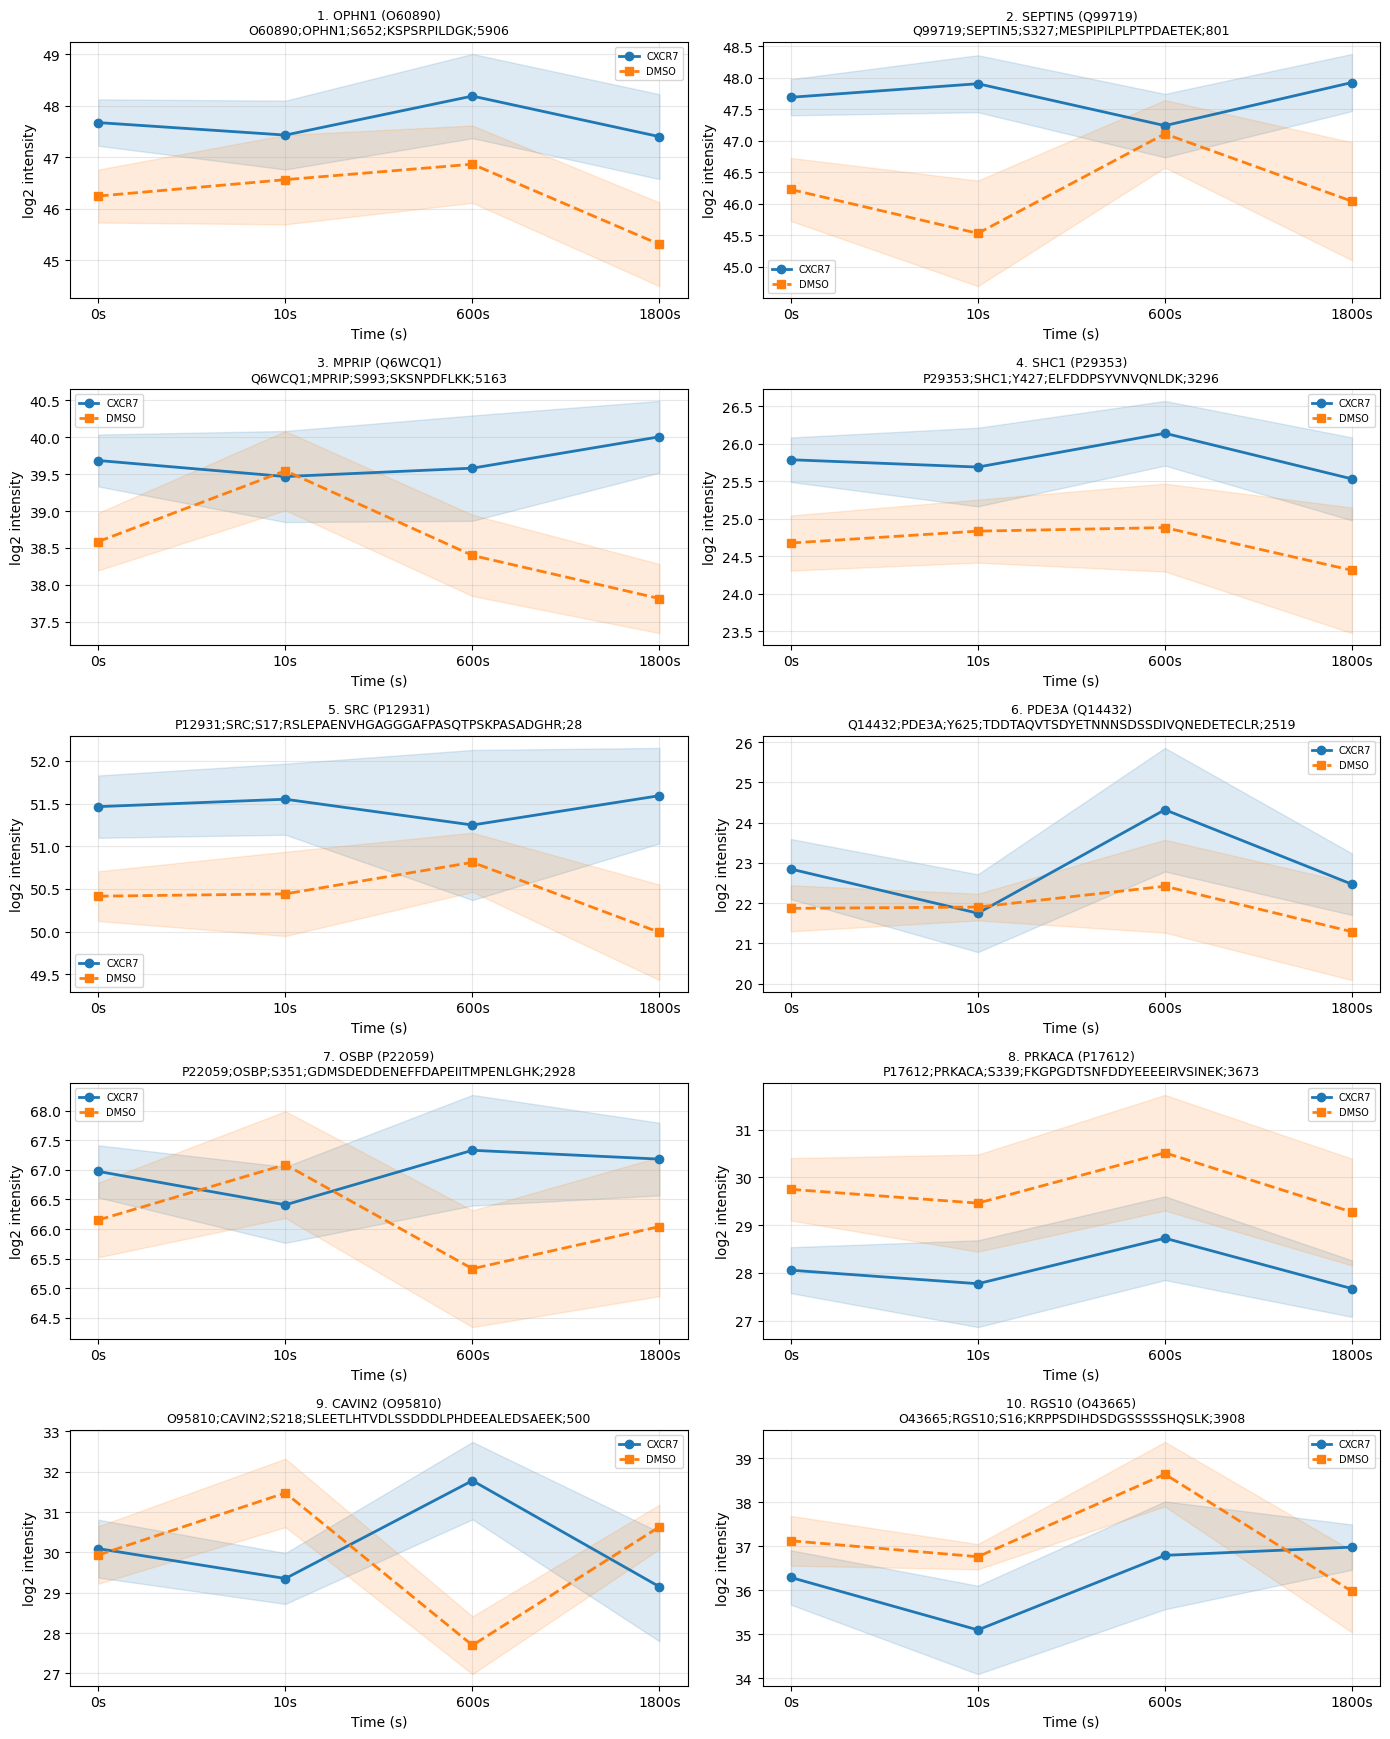


✅ Analysis complete! Results saved to: /storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation/phosphoproteomics/analysis/trajectory_deviation


In [115]:
# ======================================================
# 📊 PHOSPHOSITE TRAJECTORY DEVIATION ANALYSIS (site-level)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from scipy.stats import linregress

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_TOP': 50,                   # Number of top phosphosites to report/plot
    'PRIMARY_METRIC': 'dtw',       # Options: 'dtw', 'cosine', 'euclidean'
    'WEIGHT_ABS': 0.5,
    'WEIGHT_SLOPE': 0.25,
    'WEIGHT_AUC': 0.25,
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("✅ Analysis configuration:")
for k,v in CONFIG.items():
    print(f"   {k:20s} = {v}")

# ======================================================
# 🧩 Step 1: Ensure proper index and site info
# ======================================================
# Keep phosphosite ID as index
if phospho_intensity.index.name is None:
    phospho_intensity.index.name = "phosphosite_id"

# Copy over site metadata (UniProt, Gene symbol)
phospho_summary = phospho_summary.copy()
phospho_summary["phosphosite_id"] = phospho_intensity.index
phospho_summary = phospho_summary.set_index("phosphosite_id")
cxcr7_mean.index = phospho_summary.index
dmso_mean.index = phospho_summary.index
cxcr7_lower.index = phospho_summary.index
cxcr7_upper.index = phospho_summary.index
dmso_lower.index = phospho_summary.index
dmso_upper.index = phospho_summary.index

# ======================================================
# 🧮 Step 2: Compute all metrics per phosphosite
# ======================================================
results = []
for site_id, row in phospho_summary.iterrows():
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    v_cxcr7 = cxcr7_mean.loc[site_id].values.astype(float)
    v_dmso  = dmso_mean.loc[site_id].values.astype(float)
    
    cos_diff = cosine(v_cxcr7, v_dmso) if not np.all(v_cxcr7 == v_dmso) else 0
    alignment = dtw(v_cxcr7.reshape(-1,1), v_dmso.reshape(-1,1))
    dtw_diff = float(alignment.normalizedDistance)
    eucl_diff = np.linalg.norm(v_cxcr7 - v_dmso)
    
    # Trend metrics
    x = np.arange(len(v_cxcr7))
    s1, _, _, _, _ = linregress(x, v_cxcr7)
    s2, _, _, _, _ = linregress(x, v_dmso)
    delta_slope = s1 - s2
    delta_auc = simpson(v_cxcr7, x=x) - simpson(v_dmso, x=x)
    
    results.append([site_id, uid, gene, cos_diff, dtw_diff, eucl_diff, delta_slope, delta_auc])

metrics_df = pd.DataFrame(results, columns=[
    'phosphosite_id','uniprot_id','gene_symbol',
    'cosine','dtw','euclidean','delta_slope','delta_auc'
]).set_index('phosphosite_id')

# ======================================================
# ⚙️ Step 3: Normalize and combine
# ======================================================
for col in ['cosine','dtw','euclidean','delta_slope','delta_auc']:
    col_min, col_max = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f'{col}_norm'] = (metrics_df[col] - col_min) / (col_max - col_min)

metrics_df['combined_score'] = (
    CONFIG['WEIGHT_ABS']   * metrics_df['dtw_norm'] +
    CONFIG['WEIGHT_SLOPE'] * metrics_df['delta_slope_norm'].abs() +
    CONFIG['WEIGHT_AUC']   * metrics_df['delta_auc_norm'].abs()
)

metrics_df = metrics_df.sort_values('combined_score', ascending=False)
top_df = metrics_df.head(CONFIG['N_TOP'])

print(f"\n✅ Computed metrics for {len(metrics_df)} phosphosites")
display(top_df.head(35))

# ======================================================
# 🎨 Step 4: Visualization (with site-level labels)
# ======================================================
timepoints = ['0s','10s','600s','1800s']
n_plots = min(10, len(top_df))
fig, axes = plt.subplots(nrows=n_plots//2, ncols=2, figsize=(14, 3.5*(n_plots//2)))
axes = axes.flatten()

for i, (site_id, row) in enumerate(top_df.iloc[:n_plots].iterrows()):
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    
    cx_mean = cxcr7_mean.loc[site_id]
    cx_lo   = cxcr7_lower.loc[site_id]
    cx_hi   = cxcr7_upper.loc[site_id]
    dm_mean = dmso_mean.loc[site_id]
    dm_lo   = dmso_lower.loc[site_id]
    dm_hi   = dmso_upper.loc[site_id]
    
    ax = axes[i]
    ax.fill_between(timepoints, cx_lo, cx_hi, color='tab:blue', alpha=0.15)
    ax.plot(timepoints, cx_mean, '-o', color='tab:blue', label='CXCR7', lw=2)
    ax.fill_between(timepoints, dm_lo, dm_hi, color='tab:orange', alpha=0.15)
    ax.plot(timepoints, dm_mean, '--s', color='tab:orange', label='DMSO', lw=2)
    
    ax.set_title(f"{i+1}. {gene} ({uid})\n{site_id}", fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("log2 intensity")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ======================================================
# 💾 Step 5: Save results
# ======================================================
out_dir = base / "phosphoproteomics" / "analysis" / "trajectory_deviation"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(out_dir / "phosphosite_deviation_metrics_all.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_phosphosites.csv")

if CONFIG['SAVE_PLOTS']:
    fig.savefig(out_dir / f"top_{n_plots}_phosphosite_trajectories.png", dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')

print(f"\n✅ Analysis complete! Results saved to: {out_dir}")


## 5.3 Decision point: log2FC/psitedeviation and network betweenescentrality

In [70]:
# ======================================================
# 📂 Load prepared omics data
# ======================================================

from pathlib import Path
import pandas as pd

# Define base and input directories
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

# --- Expression mean tables ---
prot_expr_mean = pd.read_csv(in_dir / "proteome_expr_mean.csv", index_col=0)
phospho_expr_mean = pd.read_csv(in_dir / "phosphoproteome_expr_mean.csv", index_col=0)
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

# --- Fold-change tables ---
prot_fc = pd.read_csv(in_dir / "proteome_fc.csv", index_col=0)
phospho_fc = pd.read_csv(in_dir / "phosphoproteome_fc.csv", index_col=0)

# --- Detected proteins list ---
detected_uniprots = pd.read_csv(in_dir / "detected_uniprots.txt", header=None)[0].tolist()

# Summary info
print(f"✅ Loaded {len(detected_uniprots)} detected UniProt IDs.")
print(f"🧬 proteome_expr_mean shape: {prot_expr_mean.shape}")
print(f"🧪 phospho_expr_mean shape: {phospho_expr_mean.shape}")
print(f"🔗 combined_expr_mean shape: {combined_expr_mean.shape}")
print(f"📈 proteome_fc shape: {prot_fc.shape}")
print(f"📊 phospho_fc shape: {phospho_fc.shape}")

# Quick preview of the phosphoproteome FC data
display(phospho_fc.head())


✅ Loaded 2916 detected UniProt IDs.
🧬 proteome_expr_mean shape: (2326, 8)
🧪 phospho_expr_mean shape: (1315, 8)
🔗 combined_expr_mean shape: (2915, 28)
📈 proteome_fc shape: (2326, 10)
📊 phospho_fc shape: (3150, 11)


,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800,psite_id,gene_symbol
UniProt,,,,,,,,,,,
A0A1B0GUW6,-0.487630,0.237964,0.609327,-0.121132,0.768297,0.940300,-1.182801,0.005222,0.070003,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,A0A1B0GUW6
A0FGR8,0.112968,0.561838,0.836479,-0.631699,0.001758,0.061496,0.024567,0.899486,0.951119,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,ESYT2
A0FGR8,-0.336258,0.216695,0.585516,0.364801,0.180614,0.546526,0.488185,0.074705,0.302857,A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581,ESYT2
A0FGR8,0.214166,0.098726,0.419050,0.162217,0.209094,0.569764,0.333042,0.011357,0.106868,A0FGR8;ESYT2;S739;SSSSLLASPGHISVK;2582,ESYT2
A0FGR8,0.177454,0.753409,0.918455,0.484828,0.391870,0.741377,0.658353,0.246055,0.541253,A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736,ESYT2


In [72]:
# ======================================================
# 🧮 Collapse phosphosite-level FC table → protein-level summary (fixed)
# ======================================================

import numpy as np
import pandas as pd

# Ensure UniProt is a column (not index)
phospho_fc = phospho_fc.reset_index().rename(columns={'index': 'UniProt'})

# Identify logFC columns
fc_cols = [c for c in phospho_fc.columns if c.startswith("logFC")]
print(f"Detected logFC columns: {fc_cols}")

# Compute max absolute log2FC per phosphosite across timepoints
phospho_fc["max_abs_logFC"] = phospho_fc[fc_cols].abs().max(axis=1)

# Sort and select the phosphosite with the largest |logFC| per UniProt
collapsed_fc = (
    phospho_fc
    .sort_values("max_abs_logFC", ascending=False)
    .groupby("UniProt", as_index=False)
    .first()
)

# Compute mean logFC across all timepoints (for coloring or summarization)
collapsed_fc["mean_logFC"] = collapsed_fc[fc_cols].mean(axis=1)

# Keep clean, relevant columns
collapsed_fc = collapsed_fc[["UniProt", "gene_symbol", "mean_logFC", "max_abs_logFC"]]

# Sort for convenience
collapsed_fc = collapsed_fc.sort_values("max_abs_logFC", ascending=False)

print(f"\n✅ Collapsed from {len(phospho_fc)} phosphosites → {len(collapsed_fc)} unique UniProt proteins.")
display(collapsed_fc.head(10))

# Save collapsed version for network integration
out_dir = base / "analysis" / "networks" / "summaries"
out_dir.mkdir(parents=True, exist_ok=True)
collapsed_fc.to_csv(out_dir / "phosphoproteome_fc_collapsed.csv", index=False)

print(f"💾 Saved collapsed phosphoproteome FC table → {out_dir/'phosphoproteome_fc_collapsed.csv'}")


Detected logFC columns: ['logFC.10', 'logFC.600', 'logFC.1800']

✅ Collapsed from 3150 phosphosites → 1315 unique UniProt proteins.


,UniProt,gene_symbol,mean_logFC,max_abs_logFC
167,O95810,CAVIN2,0.157718,4.082586
1188,Q9UDT6,CLIP2,-1.446950,2.325571
725,Q6WCQ1,MPRIP,1.096298,2.187286
212,P07359,GP1BA,0.665256,2.113596
1260,Q9Y2Q0,ATP8A1,0.476136,2.007445
1056,Q9C0C9,UBE2O,-0.805276,1.979999
815,Q8IZ21,PHACTR4,-0.749431,1.920231
564,Q14432,PDE3A,0.976598,1.901809
1189,Q9UDY2,TJP2,0.087316,1.892123
453,Q00577,PURA,-0.616674,1.844774


💾 Saved collapsed phosphoproteome FC table → analysis/networks/summaries/phosphoproteome_fc_collapsed.csv


In [73]:
# Collapse site-level metrics_df → protein-level (mean or top site)
metrics_df_prot = (
    metrics_df
    .sort_values("combined_score", ascending=False)
    .groupby("uniprot_id", as_index=False)
    .first()  # top site per protein by dynamic deviation
)

metrics_df_prot = metrics_df_prot[["uniprot_id", "gene_symbol", "combined_score"]]
metrics_df_prot = metrics_df_prot.rename(columns={
    "uniprot_id": "UniProt",
    "combined_score": "dyn_deviation"
})

print(f"✅ Collapsed trajectory deviation to {len(metrics_df_prot)} proteins")
display(metrics_df_prot.head(10))


✅ Collapsed trajectory deviation to 1315 proteins


,UniProt,gene_symbol,dyn_deviation
0,A0A1B0GUW6,NA,0.318928
1,A0FGR8,ESYT2,0.427180
2,A1A4S6,ARHGAP10,0.299838
3,A1L390,PLEKHG3,0.297009
4,A2A2Y4,FRMD3,0.383578
5,A2RRP1,NBAS,0.256866
6,A2RUS2,DENND3,0.345977
7,A6NFX1,MFSD2B,0.299007
8,A6QL63,ABTB3,0.325786
9,A7E2V4,ZSWIM8,0.338478


In [74]:
merged_fc_dyn = pd.merge(
    collapsed_fc,
    metrics_df_prot,
    on=["UniProt", "gene_symbol"],
    how="outer"
).fillna({"mean_logFC": 0, "max_abs_logFC": 0, "dyn_deviation": 0})

display(merged_fc_dyn.head(10))


,UniProt,gene_symbol,mean_logFC,max_abs_logFC,dyn_deviation
0,A0A1B0GUW6,A0A1B0GUW6,-0.597188,1.182801,0.000000
1,A0A1B0GUW6,NA,0.000000,0.000000,0.318928
2,A0FGR8,ESYT2,0.440211,0.658353,0.427180
3,A1A4S6,ARHGAP10,-0.068705,0.244482,0.299838
4,A1L390,PLEKHG3,0.046903,0.279061,0.297009
5,A2A2Y4,FRMD3,0.274965,0.839885,0.383578
6,A2RRP1,NBAS,0.025268,0.056870,0.256866
7,A2RUS2,DENND3,-0.140743,0.263901,0.345977
8,A6NFX1,MFSD2B,0.130159,0.285341,0.299007
9,A6QL63,ABTB3,0.296745,0.516953,0.325786


In [78]:
import pandas as pd
import numpy as np

# ======================================================
# 1️⃣ Collapse phosphosites to one per UniProt (top by combined_score)
# ======================================================
collapsed_sites = (
    top_df.sort_values("combined_score", ascending=False)
          .groupby("uniprot_id", as_index=False)
          .first()
)

# Classify CXCR7 vs DMSO direction
def classify_dir(x, thr=0.05):
    if x > thr:
        return "upregulated"
    elif x < -thr:
        return "downregulated"
    else:
        return "neutral"

collapsed_sites["regulation"] = collapsed_sites["delta_slope"].apply(classify_dir)
collapsed_sites = collapsed_sites.rename(columns={"uniprot_id": "UniProt"})

print(f"✅ Collapsed {len(top_df)} phosphosites → {len(collapsed_sites)} proteins")
display(collapsed_sites.head(5))

# ======================================================
# 2️⃣ Merge collapsed phosphosite data with your igraph GCC
# ======================================================
# g_gcc is your giant connected component (igraph object)
node_names = g_gcc.vs["name"]  # UniProt IDs in GCC
nodes_df = pd.DataFrame({"UniProt": node_names})

merged = (
    nodes_df.merge(
        collapsed_sites[["UniProt", "gene_symbol", "delta_slope", "combined_score", "regulation"]],
        on="UniProt",
        how="left"
    )
    .fillna({"gene_symbol": "", "delta_slope": 0, "combined_score": 0, "regulation": "neutral"})
)

print(f"✅ Merged phospho metrics to GCC ({merged.shape[0]} total nodes)")
display(merged.head(10))

# ======================================================
# 3️⃣ Compute signal strength (signed combined score)
# ======================================================
merged["signal_strength"] = merged["combined_score"] * np.sign(merged["delta_slope"])

# Optional color code for plotting
merged["color"] = merged["regulation"].map({
    "upregulated": "red",
    "downregulated": "blue",
    "neutral": "gray"
})

# ======================================================
# 4️⃣ Attach data back to igraph node attributes
# ======================================================
g_gcc.vs["signal_strength"] = merged.set_index("UniProt").loc[g_gcc.vs["name"], "signal_strength"].tolist()
g_gcc.vs["regulation"] = merged.set_index("UniProt").loc[g_gcc.vs["name"], "regulation"].tolist()
g_gcc.vs["color"] = merged.set_index("UniProt").loc[g_gcc.vs["name"], "color"].tolist()

print("🎨 Annotated igraph GCC with signal_strength + regulation flags.")

# ======================================================
# 5️⃣ Optional — export for Cytoscape
# ======================================================
out_path = in_dir.parent / "cxcr7_vs_dmso_annotated.graphml"
g_gcc.write_graphml(str(out_path))
print(f"💾 Saved annotated GCC to: {out_path}")

# ======================================================
# 6️⃣ Prepare pseudo-log2FC table for downstream reach analysis
# ======================================================
log2fc_df = merged.set_index("UniProt")[["signal_strength"]].rename(columns={"signal_strength": "Combined"})
print(f"✅ Generated pseudo log2FC table for influence analysis: {log2fc_df.shape}")
display(log2fc_df.head(10))


✅ Collapsed 50 phosphosites → 47 proteins


,UniProt,gene_symbol,cosine,dtw,euclidean,delta_slope,delta_auc,cosine_norm,dtw_norm,euclidean_norm,delta_slope_norm,delta_auc_norm,combined_score,regulation
0,O14639,ABLIM1,0.001105,0.504391,2.057053,0.212694,1.135433,0.000598,0.442014,0.423697,0.628323,0.659525,0.542969,upregulated
1,O43182,ARHGAP6,0.000385,0.463287,1.834907,0.334844,1.327191,0.000208,0.405626,0.377668,0.740081,0.679708,0.557760,upregulated
2,O43665,RGS10,0.000470,0.725852,2.808364,0.534542,-3.783795,0.000254,0.638067,0.579371,0.922788,0.141767,0.585172,upregulated
3,O60890,OPHN1,0.000045,0.952527,2.986638,0.245150,3.754927,0.000024,0.838737,0.616310,0.658018,0.935233,0.817681,upregulated
4,O75962,TRIO,0.004389,0.372792,1.679757,0.307192,0.907695,0.002374,0.325513,0.345520,0.714781,0.635555,0.500341,upregulated


✅ Merged phospho metrics to GCC (581 total nodes)


,UniProt,gene_symbol,delta_slope,combined_score,regulation
0,P0DP24,,0.0,0.0,neutral
1,Q9Y210,,0.0,0.0,neutral
2,P06241,,0.0,0.0,neutral
3,P49137,,0.0,0.0,neutral
4,Q16539,,0.0,0.0,neutral
5,P31749,,0.0,0.0,neutral
6,O15111,,0.0,0.0,neutral
7,P19838,,0.0,0.0,neutral
8,P27986,,0.0,0.0,neutral
9,P78536,,0.0,0.0,neutral


🎨 Annotated igraph GCC with signal_strength + regulation flags.
💾 Saved annotated GCC to: analysis/networks/cxcr7_vs_dmso_annotated.graphml
✅ Generated pseudo log2FC table for influence analysis: (581, 1)


,Combined
UniProt,
P0DP24,0.0
Q9Y210,0.0
P06241,0.0
P49137,0.0
Q16539,0.0
P31749,0.0
O15111,0.0
P19838,0.0
P27986,0.0


In [84]:
# ======================================================
# 🧬 Combine mapping sources
# ======================================================
# Each table must have UniProt ID and gene_symbol columns
prot_map = prot_fc.reset_index()[["UniProt", "gene_symbol"]].drop_duplicates()
phospho_map = phospho_fc[["UniProt", "gene_symbol"]].drop_duplicates()

# Merge both
combined_map = pd.concat([prot_map, phospho_map], ignore_index=True).drop_duplicates(subset="UniProt")

# Create dictionary
id_to_symbol = combined_map.set_index("UniProt")["gene_symbol"].to_dict()
print(f"✅ Created UniProt → gene_symbol mapping for {len(id_to_symbol)} unique IDs")

# ======================================================
# 🧩 Apply mapping to each Top_* table
# ======================================================
top_tables_mapped = {}
for name, tab in top_tables.items():
    # Reset index if necessary
    if tab.index.name == "UniProt":
        tab = tab.reset_index()

    # Add gene symbol column
    tab["gene_symbol"] = tab["UniProt"].map(id_to_symbol).fillna("")

    # Move gene_symbol to front for readability
    cols = ["UniProt", "gene_symbol"] + [c for c in tab.columns if c not in ["UniProt", "gene_symbol"]]
    top_tables_mapped[name] = tab[cols]

# ======================================================
# 🧾 Display all mapped role-family tables
# ======================================================
print("\n🌟 Top proteins per functional family (with gene symbols):")
for name, tab in top_tables_mapped.items():
    print(f"\n— {name} —")
    display(tab)

# ======================================================
# 💾 Optional: export combined file
# ======================================================
mapped_path = in_dir.parent / "cxcr7_roles_igraph_with_symbols.csv"
pd.concat(top_tables_mapped, names=["role_family"]).to_csv(mapped_path)

print(f"💾 Saved all top-ranked role-family tables with gene symbols → {mapped_path}")


✅ Created UniProt → gene_symbol mapping for 2915 unique IDs

🌟 Top proteins per functional family (with gene symbols):

— Top_Receptor_like —


,UniProt,gene_symbol,ReceptorScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,P0DP24,CALM2,0.084760,0.000000,0.000000,0.466842,0.0,3.181818,0.88
1,Q15118,PDK1,0.039636,0.000000,0.000000,0.142376,0.0,2.857143,0.84
2,Q9Y2U5,MAP3K2,0.030439,0.000000,0.000000,0.140773,0.0,3.190476,0.84
3,O60890,OPHN1,0.025607,0.817681,0.817681,0.290735,0.0,3.318182,0.88
4,Q12913,PTPRJ,0.025536,0.000000,0.000000,0.106959,0.0,2.714286,0.84
5,O60271,SPAG9,0.018792,0.000000,0.000000,0.245385,0.0,3.714286,0.84
6,Q13464,ROCK1,0.017161,0.000000,0.000000,0.032560,0.0,3.476190,0.84
7,P02751,FN1,0.017128,0.000000,0.000000,0.084493,0.0,3.476190,0.84
8,O14775,GNB5,0.017089,0.000000,0.000000,0.152355,0.0,3.809524,0.84
9,P40189,IL6ST,0.017014,0.000000,0.000000,0.141462,0.0,3.523810,0.84



— Top_Adapter_like —


,UniProt,gene_symbol,AdapterScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,P12931,SRC,0.689919,0.685982,0.685982,0.379839,30798.463860,2.000000,0.84
1,P31749,AKT1,0.581198,0.000000,0.000000,0.338350,26749.364661,2.238095,0.84
2,P17252,PRKCA,0.342299,0.000000,0.000000,0.078403,19551.671854,2.047619,0.84
3,Q16539,MAPK14,0.285624,0.000000,0.000000,0.365353,12885.704631,2.714286,0.84
4,P28482,MAPK1,0.279347,0.000000,0.000000,0.060160,16230.523031,2.476190,0.84
5,P17612,PRKACA,0.258519,0.612314,0.612314,0.427957,11151.562233,2.047619,0.84
6,P63000,RAC1,0.190879,0.000000,0.000000,0.103893,10651.000049,2.476190,0.84
7,P42574,CASP3,0.169635,0.000000,0.000000,0.049085,9960.129944,2.809524,0.84
8,P35568,IRS1,0.161190,0.000000,0.000000,0.127737,8804.192305,2.428571,0.84
9,P27361,MAPK3,0.142298,0.000000,0.000000,0.063933,8238.432352,2.523810,0.84



— Top_Kinase_like —


,UniProt,gene_symbol,KinaseScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,Q14432,PDE3A,0.393007,0.642709,0.642709,1.000000,0.000000,0.000000,0.04
1,O43665,RGS10,0.357824,0.585172,0.585172,1.000000,0.000000,0.000000,0.04
2,Q9UDT6,CLIP2,0.356699,0.583332,0.583332,1.000000,0.000000,0.000000,0.04
3,O76074,PDE5A,0.322202,0.526917,0.526917,1.000000,0.000000,0.000000,0.04
4,P12931,SRC,0.318660,0.685982,0.685982,0.379839,30798.463860,2.000000,0.84
5,Q96SB3,PPP1R9B,0.305022,0.498821,0.498821,1.000000,0.000000,0.000000,0.04
6,P17612,PRKACA,0.272609,0.612314,0.612314,0.427957,11151.562233,2.047619,0.84
7,P50552,VASP,0.187874,0.511568,0.511568,0.592890,209.520699,2.952381,0.84
8,P29353,SHC1,0.174404,0.709608,0.709608,0.368436,1317.106387,2.571429,0.84
9,O60890,OPHN1,0.149143,0.817681,0.817681,0.290735,0.000000,3.318182,0.88



— Top_TF_sinks —


,UniProt,gene_symbol,TFScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,Q14432,PDE3A,1.048020e-01,0.642709,0.642709,1.000000,0.000000,0.000000,0.04
1,Q96SB3,PPP1R9B,8.133919e-02,0.498821,0.498821,1.000000,0.000000,0.000000,0.04
2,O43665,RGS10,4.770991e-02,0.585172,0.585172,1.000000,0.000000,0.000000,0.04
3,Q9UDT6,CLIP2,4.755983e-02,0.583332,0.583332,1.000000,0.000000,0.000000,0.04
4,O76074,PDE5A,4.296024e-02,0.526917,0.526917,1.000000,0.000000,0.000000,0.04
5,P50552,VASP,7.418628e-11,0.511568,0.511568,0.592890,209.520699,2.952381,0.84
6,P29353,SHC1,4.263202e-11,0.709608,0.709608,0.368436,1317.106387,2.571429,0.84
7,P60709,ACTB,1.554914e-11,0.495129,0.495129,0.385180,4021.649431,2.952381,0.84
8,O75962,TRIO,1.153675e-11,0.500341,0.500341,0.282809,0.000000,3.380952,0.84
9,P12931,SRC,9.104580e-12,0.685982,0.685982,0.379839,30798.463860,2.000000,0.84



— Top_Local_amplifiers —


,UniProt,gene_symbol,LocalAmpScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,O76074,PDE5A,1.000000,0.526917,0.526917,1.000000,0.000000,0.000000,0.04
1,O43665,RGS10,1.000000,0.585172,0.585172,1.000000,0.000000,0.000000,0.04
2,Q9UDT6,CLIP2,1.000000,0.583332,0.583332,1.000000,0.000000,0.000000,0.04
3,Q96SB3,PPP1R9B,1.000000,0.498821,0.498821,1.000000,0.000000,0.000000,0.04
4,Q14432,PDE3A,1.000000,0.642709,0.642709,1.000000,0.000000,0.000000,0.04
5,Q9Y210,TRPC6,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.04
6,P05067,APP,0.535521,0.000000,0.000000,0.540541,286.000000,0.000000,0.04
7,P50552,VASP,0.364874,0.511568,0.511568,0.592890,209.520699,2.952381,0.84
8,Q5JRX3,PITRM1,0.287849,0.000000,0.000000,0.330418,0.000000,1.000000,0.04
9,P07339,CTSD,0.287849,0.000000,0.000000,0.330418,0.000000,1.000000,0.04



— Top_Silent_conduits —


,UniProt,gene_symbol,SilentConduitScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,Q9Y210,TRPC6,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.04
1,P05067,APP,0.540541,0.000000,0.000000,0.540541,286.000000,0.000000,0.04
2,P78536,ADAM17,0.482948,0.000000,0.000000,0.482948,571.021685,3.333333,0.84
3,P0DP24,CALM2,0.466842,0.000000,0.000000,0.466842,0.000000,3.181818,0.88
4,P49137,MAPKAPK2,0.433149,0.000000,0.000000,0.433149,1238.549449,3.285714,0.84
5,P06241,FYN,0.390712,0.000000,0.000000,0.390712,4200.646077,2.476190,0.84
6,Q96SB3,PPP1R9B,0.389956,0.498821,0.498821,1.000000,0.000000,0.000000,0.04
7,O15111,CHUK,0.378586,0.000000,0.000000,0.378586,705.675735,3.857143,0.84
8,Q16539,MAPK14,0.365353,0.000000,0.000000,0.365353,12885.704631,2.714286,0.84
9,P27986,PIK3R1,0.358726,0.000000,0.000000,0.358726,1221.408208,2.809524,0.84



— Top_Effectors —


,UniProt,gene_symbol,EffectorScore,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,O60890,OPHN1,0.974026,0.817681,0.817681,0.290735,0.000000,3.318182,0.88
1,Q14432,PDE3A,0.786015,0.642709,0.642709,1.000000,0.000000,0.000000,0.04
2,P29353,SHC1,0.755197,0.709608,0.709608,0.368436,1317.106387,2.571429,0.84
3,O43665,RGS10,0.715649,0.585172,0.585172,1.000000,0.000000,0.000000,0.04
4,Q9UDT6,CLIP2,0.713398,0.583332,0.583332,1.000000,0.000000,0.000000,0.04
5,O76074,PDE5A,0.644404,0.526917,0.526917,1.000000,0.000000,0.000000,0.04
6,P02671,FGA,0.632989,0.524393,0.524393,0.345982,0.000000,3.454545,0.88
7,Q9Y4H4,GPSM3,0.628223,0.520445,0.520445,0.426475,0.000000,3.818182,0.88
8,P50552,VASP,0.613307,0.511568,0.511568,0.592890,209.520699,2.952381,0.84
9,Q96SB3,PPP1R9B,0.610044,0.498821,0.498821,1.000000,0.000000,0.000000,0.04



— Top_FlexibleComposite —


,UniProt,gene_symbol,FlexComposite,signal_strength,abs_signal_strength,ppr_reach,betweenness,avg_dist_to_top,coverage_to_top
0,Q14432,PDE3A,0.738077,0.642709,0.642709,1.000000,0.000000,0.000000,0.04
1,O43665,RGS10,0.716967,0.585172,0.585172,1.000000,0.000000,0.000000,0.04
2,Q9UDT6,CLIP2,0.716292,0.583332,0.583332,1.000000,0.000000,0.000000,0.04
3,O76074,PDE5A,0.695594,0.526917,0.526917,1.000000,0.000000,0.000000,0.04
4,Q96SB3,PPP1R9B,0.685286,0.498821,0.498821,1.000000,0.000000,0.000000,0.04
5,P12931,SRC,0.675577,0.685982,0.685982,0.379839,30798.463860,2.000000,0.84
6,P17612,PRKACA,0.571495,0.612314,0.612314,0.427957,11151.562233,2.047619,0.84
7,P50552,VASP,0.535557,0.511568,0.511568,0.592890,209.520699,2.952381,0.84
8,P29353,SHC1,0.528737,0.709608,0.709608,0.368436,1317.106387,2.571429,0.84
9,O60890,OPHN1,0.523544,0.817681,0.817681,0.290735,0.000000,3.318182,0.88


💾 Saved all top-ranked role-family tables with gene symbols → analysis/networks/cxcr7_roles_igraph_with_symbols.csv


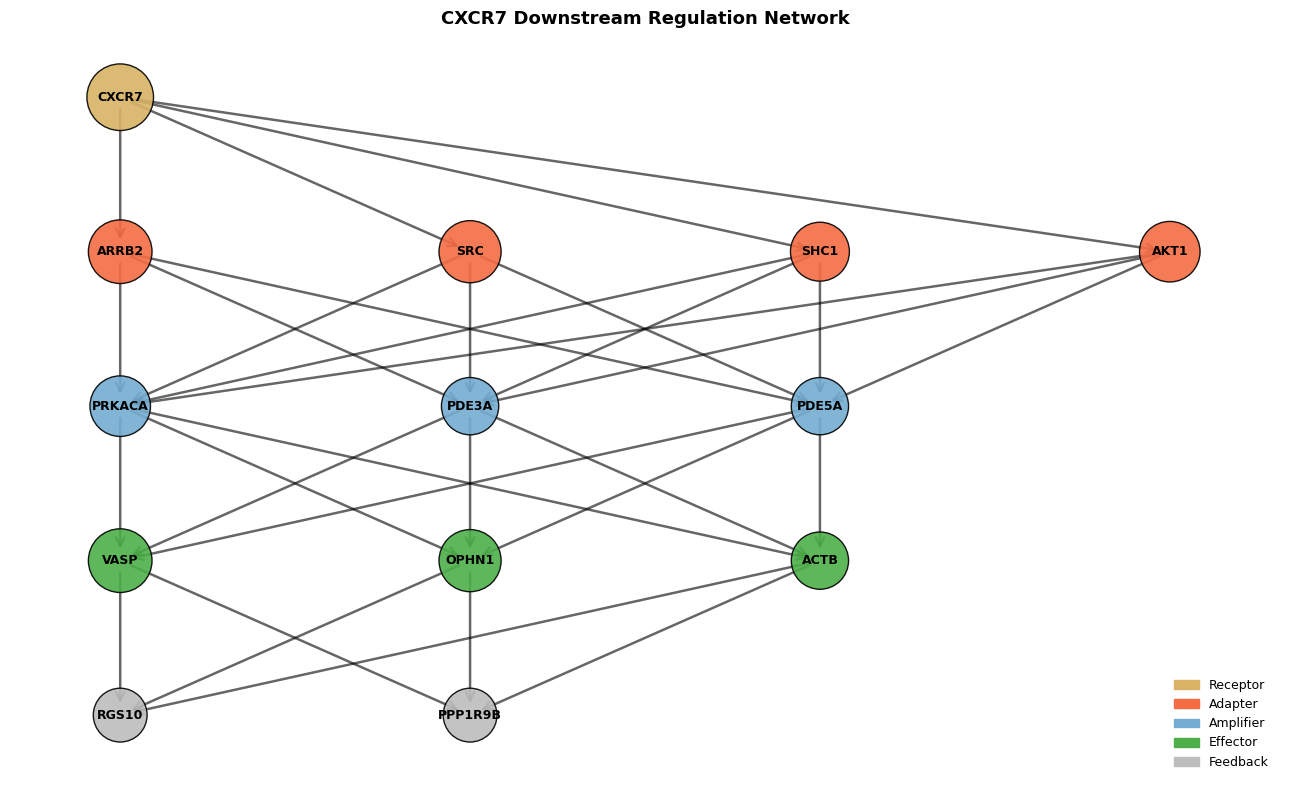

In [85]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def draw_cxcr7_network(node_roles, edges=None, title="CXCR7 Downstream Regulation Network"):
    """
    Draw an intelligent hierarchical network for CXCR7 downstream signaling.

    Parameters
    ----------
    node_roles : pd.DataFrame
        DataFrame with columns:
        - 'node' (UniProt or symbol)
        - 'role' (Receptor, Adapter, Amplifier, Effector, Feedback)
        - 'score' (optional numeric for node size)
    edges : list of tuples, optional
        List of directed edges (source, target). If None, edges are inferred by layer proximity.
    title : str
        Figure title
    """

    # Define color palette by role family
    colors = {
        "Receptor": "#d8b365",
        "Adapter": "#f46d43",
        "Amplifier": "#74add1",
        "Effector": "#4daf4a",
        "Feedback": "#bdbdbd",
    }

    # Assign vertical layer positions
    role_y = {
        "Receptor": 5,
        "Adapter": 4,
        "Amplifier": 3,
        "Effector": 2,
        "Feedback": 1,
    }

    # Default size
    if "score" not in node_roles.columns:
        node_roles["score"] = 1.0

    # Build graph
    G = nx.DiGraph()
    for _, row in node_roles.iterrows():
        G.add_node(row["node"], role=row["role"], score=row["score"])

    # Add default edges (if not given)
    if edges is None:
        # Sort by layer proximity — connect layer to next lower layer
        layers = ["Receptor", "Adapter", "Amplifier", "Effector", "Feedback"]
        edges = []
        for i in range(len(layers) - 1):
            src_layer = node_roles[node_roles["role"] == layers[i]]["node"]
            tgt_layer = node_roles[node_roles["role"] == layers[i + 1]]["node"]
            for s in src_layer:
                for t in tgt_layer:
                    edges.append((s, t))
    G.add_edges_from(edges)

    # Position nodes in layered layout
    pos = {}
    for role, y in role_y.items():
        nodes = node_roles[node_roles["role"] == role]["node"].tolist()
        n = len(nodes)
        if n > 0:
            x_positions = list(range(n))
            for i, node in enumerate(nodes):
                pos[node] = (x_positions[i], y)

    # Plot
    plt.figure(figsize=(13, 8))
    node_colors = [colors.get(G.nodes[n]["role"], "white") for n in G.nodes]
    node_sizes = [300 + 2000 * G.nodes[n]["score"] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors="black", alpha=0.9)
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, width=1.8, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    # Legend
    from matplotlib.patches import Patch
    legend_elems = [Patch(color=c, label=r) for r, c in colors.items()]
    plt.legend(handles=legend_elems, loc="lower right", frameon=False, fontsize=9)

    plt.title(title, fontsize=13, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Example input from your data
data = [
    ("CXCR7", "Receptor", 1.0),
    ("ARRB2", "Adapter", 0.9),
    ("SRC", "Adapter", 0.85),
    ("SHC1", "Adapter", 0.75),
    ("AKT1", "Adapter", 0.8),
    ("PRKACA", "Amplifier", 0.8),
    ("PDE3A", "Amplifier", 0.7),
    ("PDE5A", "Amplifier", 0.7),
    ("VASP", "Effector", 0.9),
    ("OPHN1", "Effector", 0.85),
    ("ACTB", "Effector", 0.7),
    ("RGS10", "Feedback", 0.6),
    ("PPP1R9B", "Feedback", 0.6),
]

node_roles = pd.DataFrame(data, columns=["node", "role", "score"])

draw_cxcr7_network(node_roles)
